# FORECASTING & PREDICTIVE MODELLING

Install and load the packages and libraries necessary for code generation.

In [ ]:
# pip install ipywidgets itertools matplotlib numpy pandas pickle sklearn sqlalchemy statsmodels tensorflow warnings xgboost

In [3]:
from sqlalchemy import create_engine
from ipywidgets import Dropdown, interact, VBox
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
import numpy as np
import pandas as pd
from itertools import product
import pickle
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

Load the MYSQL database using SQLAlchemy engine functionality.

In [4]:
# Connection details
host = '34.23.64.152'
user = 'readonly_user'
password = 'readonly'
database = 'testing'

# Create an SQLAlchemy engine
engine = create_engine(f'mysql+mysqlconnector://{user}:{password}@{host}/{database}')

# Query the table and load data into a DataFrame
query = "SELECT * FROM daily_demand"
daily_demand_df = pd.read_sql(query, engine)

# Display first few rows of the DataFrame
print(daily_demand_df.head())

       period respondent                respondent_name type  \
0  2019-01-01        AEC  PowerSouth Energy Cooperative    D   
1  2019-01-01        AEC  PowerSouth Energy Cooperative   NG   
2  2019-01-02        AEC  PowerSouth Energy Cooperative    D   
3  2019-01-02        AEC  PowerSouth Energy Cooperative   NG   
4  2019-01-02        AEC  PowerSouth Energy Cooperative   TI   

           type_name timezone timezone_description    value    value_units  
0             Demand  Eastern              Eastern   9721.0  megawatthours  
1     Net generation  Eastern              Eastern   9858.0  megawatthours  
2             Demand  Eastern              Eastern   9689.0  megawatthours  
3     Net generation  Eastern              Eastern  10085.0  megawatthours  
4  Total interchange  Eastern              Eastern    401.0  megawatthours  


Create a dropdown to choose a specific balancing authority and energy metric.

In [ ]:
# List of options
authority_options = [
    "AEC", "AECI", "AVA", "AVRN", "AZPS", "BANC", "BPAT", "CHPD", "CISO", "CPLE", "CPLW", "DEAA", "DOPD", "DUK",
    "EEI", "EPE", "ERCO", "FMPP", "FPC", "FPL", "GCPD", "GLHB", "GRID", "GRIF", "GVL", "GWA", "HGMA", "HST", "IID",
    "IPCO", "ISNE", "JEA", "LDWP", "LGEE", "MISO", "NEVP", "NSB", "NWMT", "NYIS", "PACE", "PACW", "CAL", "CAR", "CENT",
    "FLA", "MIDA", "MIDW", "NE", "NW", "NY", "PGE", "PJM", "PNM", "PSCO", "PSEI", "SC", "SCEG", "SCL", "Region: SE",
    "SEC", "SEPA", "SOCO", "SPA", "SRP", "Region: SW", "SWPP", "TAL", "TEC", "Region: TEN", "TEPC", "Region: TEX",
    "TIDC", "TPWR", "TVA", "Region: US48", "WACM", "WALC", "WAUW", "WWA", "YAD"
]

metric_options = ["Demand", "Net generation", "Total interchange"]

# Variables to store the selections
selected_authority = None
selected_metric = None

# Define the function to handle selections
def dropdown(authority_choice, metric_choice):
    global selected_authority, selected_metric
    selected_authority = authority_choice
    selected_metric = metric_choice
    print(f"Selected Authority: {selected_authority}")
    print(f"Selected Metric: {selected_metric}")

# Display the dropdowns and link them to the function
authority_dropdown = Dropdown(options=authority_options, description="Authority:")
metric_dropdown = Dropdown(options=metric_options, description="Metric:")

# Use interact with both dropdowns
interact(dropdown, authority_choice=authority_dropdown, metric_choice=metric_dropdown)

interactive(children=(Dropdown(description='Authority:', options=('AEC', 'AECI', 'AVA', 'AVRN', 'AZPS', 'BANC'…

<function __main__.dropdown(authority_choice, metric_choice)>

Perform initial exploratory data analysis by evaluating the seasonality and trend patterns in the time series data.

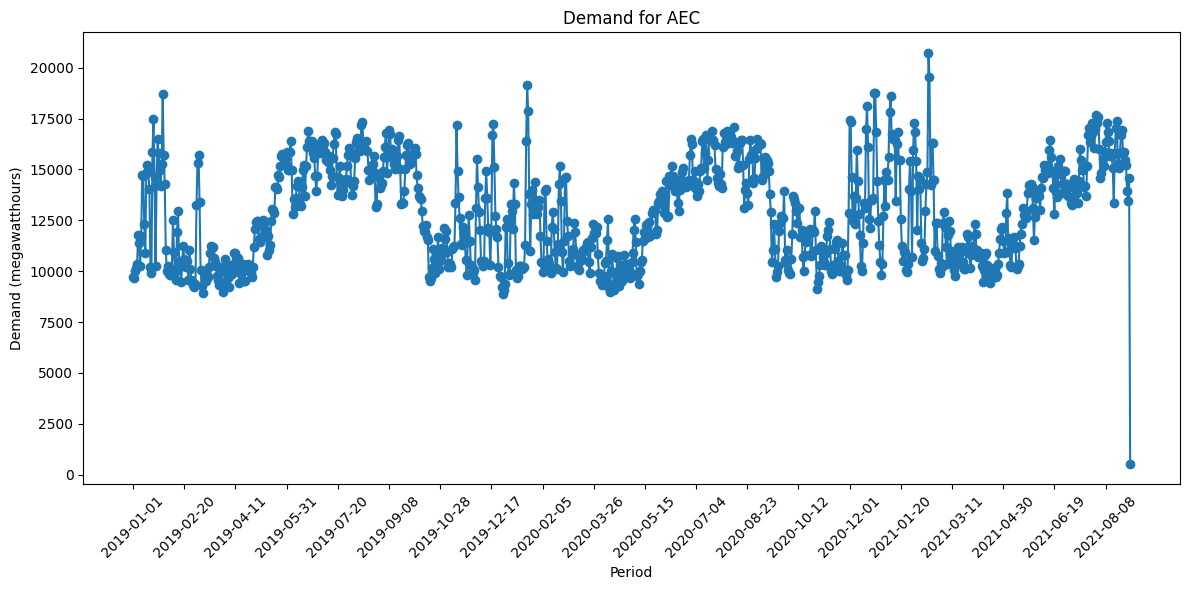

In [ ]:
def plot_demand(daily_demand_df, metric_type, respondent):
    """
    Plots the specified metric type for a specific respondent over time.

    Parameters:
    - daily_demand_df (DataFrame): The dataset containing daily demand data.
    - metric_type (str): The metric type to plot (e.g., 'Demand', 'Net generation').
    - respondent (str): The respondent identifier to filter by (e.g., 'AEC').

    Returns:
    - A plot showing the specified metric type for the given respondent over time.
    """
    # Filter the dataset by the selected metric type and respondent
    filtered_df = daily_demand_df[(daily_demand_df['type_name'] == metric_type) & 
                                  (daily_demand_df['respondent'] == respondent)]
    
    # Check if there's data to plot
    if filtered_df.empty:
        print("No data found for the selected metric type and respondent.")
        return

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_df['period'], filtered_df['value'], marker='o', linestyle='-')

    # Adjust x-axis ticks to show every 50th observation
    xtick_indices = range(0, len(filtered_df), 50)
    plt.xticks(xtick_indices, filtered_df['period'].iloc[xtick_indices], rotation=45)

    plt.xlabel("Period")
    plt.ylabel(f"{metric_type} ({filtered_df['value_units'].iloc[0]})")
    plt.title(f"{metric_type} for {respondent}")
    plt.tight_layout()
    plt.show()

plot_demand(daily_demand_df, metric_type=selected_metric, respondent=selected_authority)

Fit a SARIMA-X model to the time series data by performing grid search to tune the optimal set of hyperparameters. The performance metric chosen to select the optimal model is root mean squared error. The data is split 80/20 with the model evaluation being performed for the last 20% of the data as it is deemed most important in order to evaluate performance on latest time period. 
There is allowance for a weekly and yearly seasonality pattern using Fourier terms.

Assumptions of a SARIMA-X model:
- Covariance Stationarity: SARIMA assumes stable mean and variance, and non-stationary series can lead to unreliable predictions.
- Sudden Structural Changes: SARIMA struggles with abrupt changes, as it expects consistent seasonality.
- Non-linear Patterns or High Volatility: SARIMA may not capture non-linear dependencies or fluctuating volatility.
- Seasonality Mismatch: Incorrect seasonality parameters can lead to poor model performance.
- Insufficient Observations for Parameters: Limited data can lead to overfitting, especially with high seasonal orders.

In these cases, alternative adaptive models may perform better. Even with applying a n-th order differencing factor this may allow for a trend/linear pattern however will not completely allow for varied variance and structural shifts in the time series data.

SARIMA-X Model

In [ ]:
def fit_sarima_with_fourier_grid_search(respondent, metric_type, data, 
                                        p_range=(0, 2), d_range=(0, 1), q_range=(0, 1),
                                        P=1, D=0, Q=0, seasonal_period=7, fourier_order=5):
    """
    Fits a SARIMA model with Fourier terms for seasonality for a specified respondent and metric type.
    Performs grid search over specified ranges of (p, d, q), keeping (P, D, Q) = (1, 0, 0) and seasonal_period=7.

    Returns:
    - best_model (SARIMAXResults): The best fitted SARIMA model results on the entire dataset.
    - best_params (dict): The parameters for the best model.
    - best_rmse (float): The RMSE for the best model.
    - exog (DataFrame): The Fourier terms used as exogenous variables.
    """
    # Filter data for the specified respondent and metric type
    respondent_data = data[(data['respondent'] == respondent) & (data['type_name'] == metric_type)]
    
    if respondent_data.empty:
        print(f"No data found for respondent {respondent} with metric type '{metric_type}'")
        return None, None, None, None
    
    # Set 'period' column as the index and sort by date
    respondent_data = respondent_data.set_index('period')
    respondent_data = respondent_data.sort_index()
    
    # Ensure the index is a datetime and set frequency
    respondent_data.index = pd.to_datetime(respondent_data.index)
    inferred_freq = pd.infer_freq(respondent_data.index)
    if inferred_freq:
        respondent_data = respondent_data.asfreq(inferred_freq)
    else:
        print(f"Warning: Could not infer frequency for Authority = {respondent}, Metric = {metric_type}")
    
    # Target variable (demand values)
    y = respondent_data['value']
    
    # Generate Fourier terms for yearly seasonality
    fourier = CalendarFourier(freq='A', order=fourier_order)
    dp = DeterministicProcess(
        index=y.index,
        constant=True,
        order=1,  # Linear trend
        seasonal=True,  # Add seasonal dummy variables
        additional_terms=[fourier]
    )
    exog = dp.in_sample()
    
    # Define the training and validation sets
    split_index = int(len(y) * 0.8)  # Use 80% of data for training, 20% for validation
    train, validation = y[:split_index], y[split_index:]
    exog_train, exog_validation = exog.iloc[:split_index], exog.iloc[split_index:]
    
    # Grid search setup
    param_grid = list(product(
        range(p_range[0], p_range[1] + 1),
        range(d_range[0], d_range[1] + 1),
        range(q_range[0], q_range[1] + 1)
    ))
    
    best_rmse = float('inf')
    best_params = None
    
    for (p, d, q) in param_grid:
        try:
            # Fit SARIMA model with exogenous variables
            model = SARIMAX(train, 
                            order=(p, d, q), 
                            seasonal_order=(P, D, Q, seasonal_period), 
                            exog=exog_train, 
                            enforce_stationarity=False, 
                            enforce_invertibility=False)
            results = model.fit(disp=False)
            
            # Generate predictions for the validation set
            predictions = results.get_forecast(steps=len(validation), exog=exog_validation).predicted_mean
            
            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(validation, predictions))
            
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = {
                    'p': p, 'd': d, 'q': q,
                    'P': P, 'D': D, 'Q': Q,
                    'seasonal_period': seasonal_period
                }
            
            # print(f"Tested SARIMA(p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}, seasonal_period={seasonal_period}) - RMSE: {rmse}")
        
        except Exception as e:
            print(f"Model fitting failed for SARIMA(p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}, seasonal_period={seasonal_period}): {e}")
    
    if best_params is None:
        print("No valid model found during grid search.")
        return None, None, None, None
    
    # Fit the best model on the entire dataset with the Fourier terms
    # print(f"Fitting the best model on the entire dataset with parameters: {best_params}")
    warnings.filterwarnings("ignore")
    model = SARIMAX(y, 
                    order=(best_params['p'], best_params['d'], best_params['q']), 
                    seasonal_order=(P, D, Q, seasonal_period), 
                    exog=exog, 
                    enforce_stationarity=False, 
                    enforce_invertibility=False)
    best_model = model.fit(disp=False)
    
    return best_model, best_params, best_rmse, exog

In [ ]:
# Define the options
authority_options = [
    "AEC", "AECI", "AVA", "AVRN", "AZPS", "BANC", "BPAT", "CHPD", "CISO", "CPLE", "CPLW", "DEAA", "DOPD", "DUK",
    "EEI", "EPE", "ERCO", "FMPP", "FPC", "FPL", "GCPD", "GLHB", "GRID", "GRIF", "GVL", "GWA", "HGMA", "HST", "IID",
    "IPCO", "ISNE", "JEA", "LDWP", "LGEE", "MISO", "NEVP", "NSB", "NWMT", "NYIS", "PACE", "PACW", "CAL", "CAR", "CENT",
    "FLA", "MIDA", "MIDW", "NE", "NW", "NY", "PGE", "PJM", "PNM", "PSCO", "PSEI", "SC", "SCEG", "SCL", "Region: SE",
    "SEC", "SEPA", "SOCO", "SPA", "SRP", "Region: SW", "SWPP", "TAL", "TEC", "Region: TEN", "TEPC", "Region: TEX",
    "TIDC", "TPWR", "TVA", "Region: US48", "WACM", "WALC", "WAUW", "WWA", "YAD"
]

metric_options = ["Demand", "Net generation"]

# Dictionary to store models, parameters, and exog
results_dict = {}

# Perform grid search for each combination of authority and metric
for authority in authority_options:
    for metric in metric_options:
        # print(f"Processing: Authority = {authority}, Metric = {metric}")
        try:
            # Perform grid search and fit the best model
            best_model, best_params, best_rmse, exog = fit_sarima_with_fourier_grid_search(
                authority, metric, daily_demand_df,
                p_range=(0, 2), d_range=(0, 1), q_range=(0, 1),
                P=1, D=0, Q=0, seasonal_period=7, fourier_order=5
            )
            
            if best_model is not None:
                # Save results to dictionary
                results_dict[(authority, metric)] = {
                    "model": best_model,      # The fitted model
                    "params": best_params,    # Best parameters
                    "rmse": best_rmse,        # Best RMSE
                    "exog": exog              # Exogenous variables
                }
        except Exception as e:
            print(f"Failed for Authority = {authority}, Metric = {metric}. Error: {e}")

# Save all results to a pickled file
with open("sarima_results.pkl", "wb") as f:
    pickle.dump(results_dict, f)

print("All models and results saved to 'sarima_results.pkl'.")

# 63m 11.7s

No data found for respondent AVRN with metric type 'Demand'
Failed for Authority = BANC, Metric = Net generation. Error: 
Failed for Authority = CISO, Metric = Net generation. Error: 
No data found for respondent DEAA with metric type 'Demand'


c:\Users\adria\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed for Authority = DOPD, Metric = Net generation. Error: 
No data found for respondent EEI with metric type 'Demand'


c:\Users\adria\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed for Authority = FPL, Metric = Demand. Error: 
Failed for Authority = FPL, Metric = Net generation. Error: 
No data found for respondent GLHB with metric type 'Demand'
No data found for respondent GRID with metric type 'Demand'
Failed for Authority = GRID, Metric = Net generation. Error: 
No data found for respondent GRIF with metric type 'Demand'
Failed for Authority = GVL, Metric = Demand. Error: 
Failed for Authority = GVL, Metric = Net generation. Error: 
No data found for respondent GWA with metric type 'Demand'
Failed for Authority = GWA, Metric = Net generation. Error: 
No data found for respondent HGMA with metric type 'Demand'


c:\Users\adria\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\adria\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\adria\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\adria\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed for Authority = IID, Metric = Demand. Error: 
Failed for Authority = IID, Metric = Net generation. Error: 
Failed for Authority = JEA, Metric = Demand. Error: 
Failed for Authority = JEA, Metric = Net generation. Error: 
Failed for Authority = LDWP, Metric = Demand. Error: 
Failed for Authority = LDWP, Metric = Net generation. Error: 
Failed for Authority = LGEE, Metric = Demand. Error: 
Failed for Authority = LGEE, Metric = Net generation. Error: 
Failed for Authority = NSB, Metric = Demand. Error: 
Failed for Authority = NSB, Metric = Net generation. Error: 
Failed for Authority = NWMT, Metric = Net generation. Error: 
Failed for Authority = PGE, Metric = Demand. Error: 
Failed for Authority = PGE, Metric = Net generation. Error: 
Failed for Authority = PJM, Metric = Demand. Error: 
Failed for Authority = PJM, Metric = Net generation. Error: 
Failed for Authority = PSCO, Metric = Net generation. Error: 


c:\Users\adria\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed for Authority = SC, Metric = Demand. Error: 
Failed for Authority = SC, Metric = Net generation. Error: 
Failed for Authority = SCEG, Metric = Demand. Error: 
Failed for Authority = SCEG, Metric = Net generation. Error: 
No data found for respondent Region: SE with metric type 'Demand'
No data found for respondent Region: SE with metric type 'Net generation'
Failed for Authority = SEC, Metric = Demand. Error: 
Failed for Authority = SEC, Metric = Net generation. Error: 
No data found for respondent SEPA with metric type 'Demand'
Failed for Authority = SEPA, Metric = Net generation. Error: 
Failed for Authority = SPA, Metric = Demand. Error: 
Failed for Authority = SPA, Metric = Net generation. Error: 
Failed for Authority = SRP, Metric = Net generation. Error: 
No data found for respondent Region: SW with metric type 'Demand'
No data found for respondent Region: SW with metric type 'Net generation'
Failed for Authority = TEC, Metric = Demand. Error: 
Failed for Authority = TEC, 

c:\Users\adria\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed for Authority = WALC, Metric = Demand. Error: 
Failed for Authority = WALC, Metric = Net generation. Error: 
No data found for respondent WWA with metric type 'Demand'
Failed for Authority = WWA, Metric = Net generation. Error: 
No data found for respondent YAD with metric type 'Demand'
Failed for Authority = YAD, Metric = Net generation. Error: 
All models and results saved to 'sarima_results.pkl'.


In [ ]:
def forecast_and_append_results(daily_demand_df, loaded_results, forecast_steps=365):
    """
    Performs forecasting for each authority and metric using pre-trained models
    and appends the forecasted rows to a copy of the daily_demand_df.

    Parameters:
    - daily_demand_df (DataFrame): The dataset containing historical data.
    - loaded_results (dict): The dictionary containing models, parameters, and exogenous variables.
    - forecast_steps (int): The number of forecast steps (default is 365).

    Returns:
    - updated_df (DataFrame): A copy of the original dataframe with forecasted rows appended.
    """
    # Create a copy of the original dataframe to append forecasted rows
    updated_df = daily_demand_df[["period", "respondent", "type_name", "value"]].copy()
    updated_df["forecast"] = "history"  # Mark all existing rows as "history"

    for (authority, metric), result in loaded_results.items():
        # print(f"Processing forecast for Authority: {authority}, Metric: {metric}")

        best_model = result["model"]
        exog = result["exog"]

        if best_model is not None:
            # Check if sufficient exog rows are available
            if exog.shape[0] < forecast_steps:
                print(f"Insufficient exogenous data for Authority: {authority}, Metric: {metric}. Skipping forecast.")
                continue

            # Adjust forecast_steps if exog is smaller
            actual_forecast_steps = min(forecast_steps, exog.shape[0])
            future_exog = exog.iloc[-actual_forecast_steps:]

            # Validate shape
            required_shape = (actual_forecast_steps, exog.shape[1])
            if future_exog.shape != required_shape:
                print(f"Exog shape mismatch for Authority: {authority}, Metric: {metric}. Expected {required_shape}, got {future_exog.shape}. Skipping forecast.")
                continue

            try:
                # Perform the forecast
                forecast = best_model.get_forecast(steps=actual_forecast_steps, exog=future_exog)
                forecast_df = forecast.summary_frame()

                # Prepare the forecasted rows
                forecast_data = forecast_df[["mean"]].copy()
                forecast_data["period"] = pd.to_datetime(forecast_df.index)  # Use the forecast index as the period
                forecast_data.rename(columns={"mean": "value"}, inplace=True)
                forecast_data["respondent"] = authority
                forecast_data["type_name"] = metric
                forecast_data["forecast"] = "forecast"  # Mark these rows as "forecast"

                # Append the forecasted rows to the updated dataframe
                updated_df = pd.concat([updated_df, forecast_data], ignore_index=True)

            except Exception as e:
                print(f"Forecast failed for Authority: {authority}, Metric: {metric}. Error: {e}")
                continue

    print("Forecasting completed. Updated dataframe created with historical and forecasted data.")
    return updated_df

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_demand_with_forecast(updated_daily_demand_df, selected_authority, selected_metric):
    """
    Plots the specified metric type for a specific respondent over time,
    including both historical and forecasted data from the combined dataframe.

    Parameters:
    - updated_daily_demand_df (DataFrame): The dataframe containing historical and forecasted data.
    - selected_authority (str): The respondent identifier to filter by (e.g., 'AEC').
    - selected_metric (str): The metric type to plot (e.g., 'Demand').

    Returns:
    - A plot showing the historical and forecasted metric type for the given respondent over time.
    """
    # Filter the dataset by the selected authority and metric
    filtered_df = updated_daily_demand_df[
        (updated_daily_demand_df["respondent"] == selected_authority) &
        (updated_daily_demand_df["type_name"] == selected_metric)
    ]

    if filtered_df.empty:
        print(f"No data found for Authority: {selected_authority}, Metric: {selected_metric}")
        return

    # Ensure 'period' column is in datetime format
    filtered_df["period"] = pd.to_datetime(filtered_df["period"])

    # Separate historical and forecasted data
    historical_data = filtered_df[filtered_df["forecast"] == "history"]
    forecasted_data = filtered_df[filtered_df["forecast"] == "forecast"]

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(
        historical_data["period"],
        historical_data["value"],
        label="Historical Data",
        marker='o',
        linestyle='-'
    )
    plt.plot(
        forecasted_data["period"],
        forecasted_data["value"],
        label="Forecasted Data",
        marker='o',
        linestyle='--'
    )

    # Set x-axis limits to cover both historical and forecasted periods
    plt.xlim([historical_data["period"].min(), forecasted_data["period"].max()])

    # Format x-axis ticks
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Monthly ticks
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

    plt.xlabel("Period")
    plt.ylabel(f"{selected_metric}")
    plt.title(f"{selected_metric} for {selected_authority} (Historical + Forecast)")
    plt.legend()
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
# Load the trained SARIMA models and exogenous variables
with open("sarima_results.pkl", "rb") as f:
    loaded_results = pickle.load(f)

# Perform forecasting and get the updated DataFrame
updated_daily_demand_df = forecast_and_append_results(daily_demand_df, loaded_results)

# Save the updated DataFrame to a CSV file
updated_daily_demand_df.to_csv("sarima_complete_df.csv", index=False)

# Inspect the combined DataFrame
print(updated_daily_demand_df.tail())  # Check the last few rows for forecasted data

Insufficient exogenous data for Authority: EEI, Metric: Net generation. Skipping forecast.
Forecasting completed. Updated dataframe created with historical and forecasted data.
                     period respondent       type_name        value  forecast
650011  2025-11-03 00:00:00       WAUW  Net generation  1249.649315  forecast
650012  2025-11-04 00:00:00       WAUW  Net generation  1203.953515  forecast
650013  2025-11-05 00:00:00       WAUW  Net generation  1175.236066  forecast
650014  2025-11-06 00:00:00       WAUW  Net generation  1208.360523  forecast
650015  2025-11-07 00:00:00       WAUW  Net generation  1246.598082  forecast


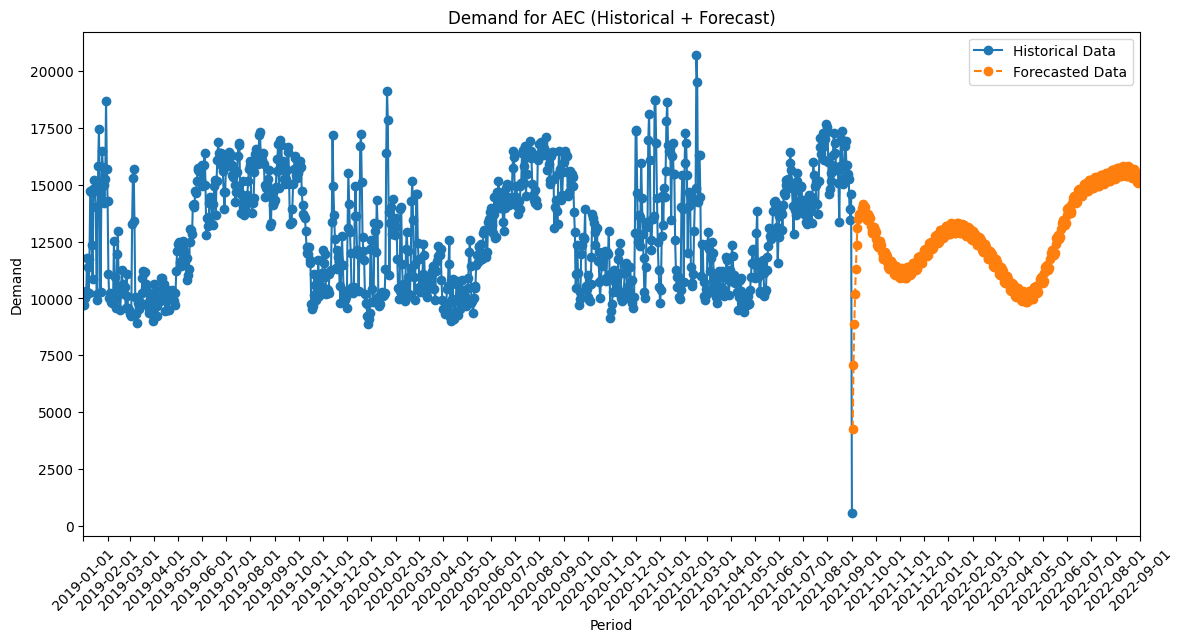

In [ ]:
# SARIMA-X Plotting
plot_demand_with_forecast(updated_daily_demand_df, selected_authority=selected_authority, selected_metric=selected_metric)

XGBoost for Time Series Summary:
- XGBoost is a boosting algorithm that uses decision trees to minimize prediction errors.
- Feature Engineering: Lagged values, rolling stats, and calendar features are needed to capture time dependencies.

Limitations and When It Breaks Down:
- Temporal Dependencies: Doesn’t naturally capture sequential patterns without engineered features.
- Error Accumulation: Multi-step forecasting can lead to error buildup.
- Seasonality & Trends: Requires explicit feature engineering for these patterns.
- Noisy Data: Can overfit or underfit with high-variance data if not tuned.
- Computation: Can be slow with large datasets and many features.

XGBoost can work well if time structure is well-engineered but may struggle with long dependencies and seasonality.

In [ ]:
def fit_xgboost_with_seasonality(daily_demand_df, metric_type, respondent, test_ratio=0.2):
    """
    Fits an XGBRegressor to time series data with seasonal features and optimized grid search for hyperparameters.

    Parameters:
        daily_demand_df (pd.DataFrame): The original dataframe containing time series data.
        metric_type (str): The metric type to filter (e.g., "Demand", "Net generation").
        respondent (str): The respondent to filter.
        test_ratio (float): The proportion of data to be used as the test set.

    Returns:
        best_model (XGBRegressor): The trained XGBRegressor model.
        best_params (dict): Best parameters found during grid search.
        test_rmse (float): The RMSE of the model on the test set.
        test_predictions (np.array): Predicted values for the test set.
        y_test (np.array): Actual values for the test set.
    """
    # Step 1: Filter the data
    filtered_df = daily_demand_df[(daily_demand_df['type_name'] == metric_type) & 
                                  (daily_demand_df['respondent'] == respondent)].copy()
    
    if filtered_df.empty:
        print(f"No data found for metric_type '{metric_type}' and respondent '{respondent}'")
        return None, None, None, None, None

    # Ensure the 'period' column is in datetime format
    filtered_df['period'] = pd.to_datetime(filtered_df['period'])
    
    # Step 2: Create lagged features and rolling statistics
    filtered_df['lag1'] = filtered_df['value'].shift(1)
    filtered_df['lag2'] = filtered_df['value'].shift(2)
    filtered_df['lag7'] = filtered_df['value'].shift(7)
    filtered_df['rolling_mean_7'] = filtered_df['value'].rolling(window=7).mean()
    filtered_df['rolling_std_7'] = filtered_df['value'].rolling(window=7).std()
    
    # Step 3: Add seasonal features
    filtered_df['day_of_week'] = filtered_df['period'].dt.dayofweek  # Day of the week (0=Monday, 6=Sunday)
    filtered_df['month'] = filtered_df['period'].dt.month            # Month of the year (1=January, 12=December)
    filtered_df['day_of_year'] = filtered_df['period'].dt.dayofyear  # Day of the year (1-365/366)
    
    # Fourier terms for complex seasonality (e.g., annual cycle)
    filtered_df['sin_day'] = np.sin(2 * np.pi * filtered_df['day_of_year'] / 365)
    filtered_df['cos_day'] = np.cos(2 * np.pi * filtered_df['day_of_year'] / 365)

    # Drop rows with NaN values due to shifting and rolling computations
    filtered_df.dropna(inplace=True)

    # Step 4: Define features and target
    features = ['lag1', 'lag2', 'lag7', 'rolling_mean_7', 'rolling_std_7',
                'day_of_week', 'month', 'sin_day', 'cos_day']
    X = filtered_df[features]
    y = filtered_df['value']

    # Step 5: Split data into training, validation, and test sets
    split_index = int(len(X) * (1 - test_ratio))
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    
    # Further split training data into train and validation sets
    X_train_main, X_val, y_train_main, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
    
    # Step 6: Perform grid search (with reduced parameter grid)
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.05, 0.1, 0.2]
    }
    
    best_rmse = float('inf')
    best_params = {}
    best_model = None

    for n_estimators in param_grid['n_estimators']:
        for learning_rate in param_grid['learning_rate']:
            model = XGBRegressor(
                n_estimators=n_estimators, 
                learning_rate=learning_rate, 
                max_depth=6,  # Default value
                random_state=1
            )
            model.fit(X_train_main, y_train_main)
            val_predictions = model.predict(X_val)
            val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
            
            if val_rmse < best_rmse:
                best_rmse = val_rmse
                best_params = {'n_estimators': n_estimators, 'learning_rate': learning_rate}
                best_model = model

    # Step 7: Evaluate the best model on the test set
    test_predictions = best_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    
    # print(f"Best RMSE on validation set: {best_rmse}")
    # print(f"Best Parameters: {best_params}")
    # print(f"RMSE on test set: {test_rmse}")
    
    return best_model, best_params, test_rmse, test_predictions, y_test

XGBoost - PICKLING
- Train and save an XGBoost model for each metric_type and respondent.
- Serialize the trained models using pickle.

In [ ]:
# Define the options
authority_options = [
    "AEC", "AECI", "AVA", "AVRN", "AZPS", "BANC", "BPAT", "CHPD", "CISO", "CPLE", "CPLW", "DEAA", "DOPD", "DUK",
    "EEI", "EPE", "ERCO", "FMPP", "FPC", "FPL", "GCPD", "GLHB", "GRID", "GRIF", "GVL", "GWA", "HGMA", "HST", "IID",
    "IPCO", "ISNE", "JEA", "LDWP", "LGEE", "MISO", "NEVP", "NSB", "NWMT", "NYIS", "PACE", "PACW", "CAL", "CAR", "CENT",
    "FLA", "MIDA", "MIDW", "NE", "NW", "NY", "PGE", "PJM", "PNM", "PSCO", "PSEI", "SC", "SCEG", "SCL", "Region: SE",
    "SEC", "SEPA", "SOCO", "SPA", "SRP", "Region: SW", "SWPP", "TAL", "TEC", "Region: TEN", "TEPC", "Region: TEX",
    "TIDC", "TPWR", "TVA", "Region: US48", "WACM", "WALC", "WAUW", "WWA", "YAD"
]

# Define the options for authorities and metrics
# authority_options = ["AEC", "AECI", "AVA"]
metric_options = ["Demand", "Net generation"]

# Dictionary to store models, parameters, and results
results_dict = {}

# Perform grid search for each combination of authority and metric
for authority in authority_options:
    for metric in metric_options:
        # print(f"Processing: Authority = {authority}, Metric = {metric}")
        try:
            # Call the updated XGBoost function with feature engineering inside
            best_model, best_params, best_rmse, predictions, y_test = fit_xgboost_with_seasonality(
                daily_demand_df, 
                metric_type=metric, 
                respondent=authority, 
                test_ratio=0.2
            )
            
            if best_model is not None:
                # Save results to dictionary
                results_dict[(authority, metric)] = {
                    "model": best_model,               # The trained model
                    "params": best_params,             # Best parameters
                    "rmse": best_rmse,                 # RMSE on the test set
                    "predictions": predictions,        # Predictions for the test set
                    "y_test": y_test.values            # Actual test values
                }
        except Exception as e:
            print(f"Failed for Authority = {authority}, Metric = {metric}. Error: {e}")

# Save all results to a pickled file
with open("xgboost_results.pkl", "wb") as f:
    pickle.dump(results_dict, f)

print("All models and results saved to 'xgboost_results.pkl'.")

No data found for metric_type 'Demand' and respondent 'AVRN'
No data found for metric_type 'Demand' and respondent 'DEAA'
No data found for metric_type 'Demand' and respondent 'EEI'
No data found for metric_type 'Demand' and respondent 'GLHB'
No data found for metric_type 'Demand' and respondent 'GRID'
No data found for metric_type 'Demand' and respondent 'GRIF'
No data found for metric_type 'Demand' and respondent 'GWA'
No data found for metric_type 'Demand' and respondent 'HGMA'
No data found for metric_type 'Demand' and respondent 'Region: SE'
No data found for metric_type 'Net generation' and respondent 'Region: SE'
No data found for metric_type 'Demand' and respondent 'SEPA'
No data found for metric_type 'Demand' and respondent 'Region: SW'
No data found for metric_type 'Net generation' and respondent 'Region: SW'
No data found for metric_type 'Demand' and respondent 'Region: TEN'
No data found for metric_type 'Net generation' and respondent 'Region: TEN'
No data found for metric_

XGBoost Forecasting & Plotting
- Load the Saved XGBoost Models
- Use for Forecasting
- Plot the results

In [ ]:
def forecast_and_append_results_xgboost(daily_demand_df, loaded_results, forecast_steps=365):
    """
    Performs forecasting for each authority and metric using pre-trained XGBoost models
    and appends the forecasted rows to a copy of the daily_demand_df.

    Parameters:
    - daily_demand_df (DataFrame): The dataset containing historical data.
    - loaded_results (dict): The dictionary containing models, parameters, and exogenous variables.
    - forecast_steps (int): The number of forecast steps (default is 365).

    Returns:
    - updated_df (DataFrame): A copy of the original dataframe with forecasted rows appended.
    """
    # Create a copy of the original dataframe to append forecasted rows
    updated_df = daily_demand_df[["period", "respondent", "type_name", "value"]].copy()
    updated_df["forecast"] = "history"  # Mark all existing rows as "history"

    for (authority, metric), result in loaded_results.items():
        # print(f"Processing forecast for Authority: {authority}, Metric: {metric}")

        best_model = result["model"]

        if best_model is not None:
            # Filter the historical data for this authority and metric
            historical_data = daily_demand_df[
                (daily_demand_df["respondent"] == authority) & 
                (daily_demand_df["type_name"] == metric)
            ][["period", "value"]].copy()
            
            # Ensure the 'period' column is in datetime format
            historical_data["period"] = pd.to_datetime(historical_data["period"])
            
            # Ensure historical data is sorted by period
            historical_data.sort_values("period", inplace=True)
            
            # Initialize a DataFrame for forecast
            forecast_data = []

            # Perform step-by-step forecasting
            for step in range(forecast_steps):
                # Generate lagged features from the last available data
                lag1 = historical_data["value"].iloc[-1]
                lag2 = historical_data["value"].iloc[-2] if len(historical_data) > 1 else lag1
                lag7 = historical_data["value"].iloc[-7] if len(historical_data) > 6 else lag1
                rolling_mean_7 = historical_data["value"].iloc[-7:].mean() if len(historical_data) > 6 else lag1
                rolling_std_7 = historical_data["value"].iloc[-7:].std() if len(historical_data) > 6 else 0

                # Add seasonal features based on the next period
                next_period = historical_data["period"].max() + pd.Timedelta(days=1)
                day_of_week = next_period.dayofweek
                month = next_period.month
                day_of_year = next_period.dayofyear
                sin_day = np.sin(2 * np.pi * day_of_year / 365)
                cos_day = np.cos(2 * np.pi * day_of_year / 365)

                # Create a feature set for prediction
                X_pred = pd.DataFrame([{
                    "lag1": lag1,
                    "lag2": lag2,
                    "lag7": lag7,
                    "rolling_mean_7": rolling_mean_7,
                    "rolling_std_7": rolling_std_7,
                    "day_of_week": day_of_week,
                    "month": month,
                    "sin_day": sin_day,
                    "cos_day": cos_day
                }])

                # Predict the next value
                next_value = best_model.predict(X_pred)[0]

                # Append the prediction to the forecast data
                forecast_data.append({
                    "period": next_period,
                    "value": next_value,
                    "respondent": authority,
                    "type_name": metric,
                    "forecast": "forecast"
                })

                # Add the forecasted value to the historical data for subsequent lags
                historical_data = pd.concat(
                    [historical_data, pd.DataFrame({"period": [next_period], "value": [next_value]})],
                    ignore_index=True
                )

            # Append the forecasted rows to the updated dataframe
            forecast_df = pd.DataFrame(forecast_data)
            updated_df = pd.concat([updated_df, forecast_df], ignore_index=True)

    print("Forecasting completed. Updated dataframe created with historical and forecasted data.")
    return updated_df

XGBoost Plotting

In [ ]:
def plot_xgboost_demand_with_forecast(updated_daily_demand_df, selected_authority, selected_metric):
    """
    Plots the specified metric type for a specific respondent over time,
    including both historical and forecasted data from the combined dataframe.

    Parameters:
    - updated_daily_demand_df (DataFrame): The dataframe containing historical and forecasted data.
    - selected_authority (str): The respondent identifier to filter by (e.g., 'AEC').
    - selected_metric (str): The metric type to plot (e.g., 'Demand').

    Returns:
    - A plot showing the historical and forecasted metric type for the given respondent over time.
    """
    # Filter the dataset by the selected authority and metric
    filtered_df = updated_daily_demand_df[
        (updated_daily_demand_df["respondent"] == selected_authority) &
        (updated_daily_demand_df["type_name"] == selected_metric)
    ]

    if filtered_df.empty:
        print(f"No data found for Authority: {selected_authority}, Metric: {selected_metric}")
        return

    # Ensure 'period' column is in datetime format
    filtered_df["period"] = pd.to_datetime(filtered_df["period"])

    # Separate historical and forecasted data
    historical_data = filtered_df[filtered_df["forecast"] == "history"]
    forecasted_data = filtered_df[filtered_df["forecast"] == "forecast"]

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(
        historical_data["period"],
        historical_data["value"],
        label="Historical Data",
        marker='o',
        linestyle='-',
        color="blue"
    )
    plt.plot(
        forecasted_data["period"],
        forecasted_data["value"],
        label="Forecasted Data",
        marker='o',
        linestyle='--',
        color="orange"
    )

    # Highlight the transition point between historical and forecasted data
    if not historical_data.empty and not forecasted_data.empty:
        plt.axvline(
            x=historical_data["period"].max(),
            color='gray',
            linestyle='--',
            alpha=0.7,
            label="Forecast Start"
        )

    # Set x-axis limits to cover both historical and forecasted periods
    plt.xlim([historical_data["period"].min(), forecasted_data["period"].max()])

    # Format x-axis ticks
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Monthly ticks
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

    plt.xlabel("Period")
    plt.ylabel(f"{selected_metric}")
    plt.title(f"{selected_metric} for {selected_authority} (Historical + Forecast)")
    plt.legend()
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
# Load the trained XGBoost models and associated data (e.g., parameters and results)
with open("xgboost_results.pkl", "rb") as f:
    loaded_results = pickle.load(f)

# Perform forecasting using the loaded XGBoost models and append forecasted rows
# The `forecast_and_append_results_xgboost` function dynamically generates lag features
updated_df = forecast_and_append_results_xgboost(daily_demand_df, loaded_results, forecast_steps=365)

# Save the complete DataFrame (historical + forecasted data) to a CSV file
updated_df.to_csv("xgboost_complete_df.csv", index=False)

# Print the last few rows of the DataFrame to inspect the appended forecasted data
print(updated_df.tail())  # Check the last few rows for forecasted data

Forecasting completed. Updated dataframe created with historical and forecasted data.
                     period respondent       type_name        value  forecast
666436  2025-11-03 00:00:00        YAD  Net generation  2490.008057  forecast
666437  2025-11-04 00:00:00        YAD  Net generation  2464.492188  forecast
666438  2025-11-05 00:00:00        YAD  Net generation  2501.277832  forecast
666439  2025-11-06 00:00:00        YAD  Net generation  2685.833496  forecast
666440  2025-11-07 00:00:00        YAD  Net generation  2499.514404  forecast


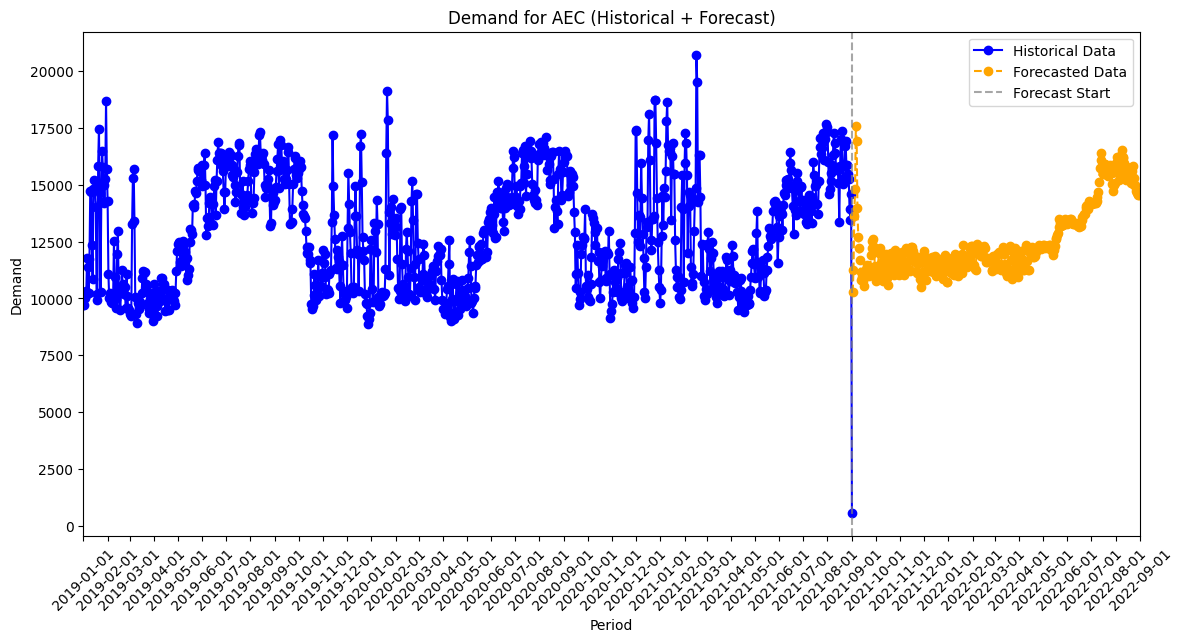

In [ ]:
# XGBoost - Plotting
plot_xgboost_demand_with_forecast(updated_df, selected_authority=selected_authority, selected_metric=selected_metric)

A Long Short-Term Memory (LSTM) network is a type of recurrent neural network (RNN) designed to learn from sequential data. LSTMs are particularly useful for time series forecasting because they can capture long-term dependencies and trends by maintaining a "memory" of previous data over many time steps.

Understanding LSTMs
- Memory Cell: LSTMs have special memory cells that enable them to remember values for long periods, which helps in learning sequential patterns.
- Gates: LSTMs use three types of gates (forget, input, and output) to control the information flow:
- Forget Gate: Decides which information to discard.
- Input Gate: Updates the cell state with new information.
- Output Gate: Decides the next hidden state and what to output.
- Stateful Learning: Unlike simple RNNs, LSTMs can retain information over long sequences, making them ideal for datasets with trends or seasonality that span long periods.

Hyperparameters to Tune
- Number of Time Steps (time_steps): Represents the sequence length (how far back the LSTM should look). A common range is 10-60 steps, depending on the dataset’s periodicity.
- Number of LSTM Units: Controls the model’s capacity to learn complex patterns. Typical values range from 50 to 200. More units increase the model’s complexity but also require more data and computation.
- Learning Rate: The rate at which the model learns during training. Lower values (e.g., 0.001) are generally better for stability, but tuning can be beneficial.
- Batch Size: The number of samples processed before the model’s internal parameters are updated. Common batch sizes are 16, 32, or 64.
- Number of Epochs: The number of complete passes through the training dataset. Too few epochs may underfit, while too many may overfit. A typical range is 50-200.
- Dropout Rate (optional): Adding dropout layers to LSTM helps reduce overfitting by randomly setting a fraction of input units to zero at each update during training.

Main Challenges and Limitations
- Overfitting: LSTMs are prone to overfitting, especially with limited data. Using dropout layers, early stopping, or cross-validation can help mitigate this.
- Data Scaling: LSTMs generally require scaled data (e.g., using MinMaxScaler or StandardScaler), as large values can cause instability in the learning process.
- Computational Cost: LSTMs can be computationally intensive, especially with large datasets and long sequences. Training can be slow without sufficient computational resources.
- Hyperparameter Tuning: Finding the right combination of time steps, LSTM units, and learning rate requires careful tuning, which can be time-consuming.
- Sensitivity to Sequence Length: Selecting an appropriate number of time steps is crucial. Too few time steps may fail to capture dependencies, while too many may introduce noise and increase computational demands.

Summary
- LSTMs are powerful for time series forecasting because they can capture long-term dependencies in sequential data.
- Hyperparameters like time steps, LSTM units, batch size, and learning rate can significantly affect performance and must be carefully tuned.
- Challenges include overfitting, computational cost, and the need for large datasets, especially when using deep LSTM architectures.

In [ ]:
def prepare_lstm_data(daily_demand_df, metric_type, respondent, time_steps=10, test_ratio=0.2):
    """
    Prepares the data for LSTM by creating lagged sequences and scaling the target variable.

    Parameters:
        daily_demand_df (pd.DataFrame): Original dataset.
        metric_type (str): Metric to filter (e.g., "Demand").
        respondent (str): Respondent to filter.
        time_steps (int): Number of time steps for LSTM input.
        test_ratio (float): Proportion of data to use as the test set.

    Returns:
        X_train, X_test, y_train, y_test, scaler: Prepared data and scaler for inverse transformations.
    """
    filtered_df = daily_demand_df[(daily_demand_df['type_name'] == metric_type) & 
                                  (daily_demand_df['respondent'] == respondent)].copy()
    if filtered_df.empty:
        print(f"No data found for metric_type '{metric_type}' and respondent '{respondent}'")
        return None, None, None, None, None

    scaler = MinMaxScaler(feature_range=(0, 1))
    filtered_df['value'] = scaler.fit_transform(filtered_df[['value']])

    data, target = [], []
    for i in range(time_steps, len(filtered_df)):
        data.append(filtered_df['value'].values[i-time_steps:i])
        target.append(filtered_df['value'].values[i])
    data, target = np.array(data), np.array(target)

    split_index = int(len(data) * (1 - test_ratio))
    X_train, X_test = data[:split_index], data[split_index:]
    y_train, y_test = target[:split_index], target[split_index:]

    return X_train, X_test, y_train, y_test, scaler

def train_lstm_model(X_train, y_train, time_steps, units, batch_size, learning_rate, early_stopping):
    """
    Trains an LSTM model with the specified hyperparameters.

    Parameters:
        X_train (np.array): Training input data.
        y_train (np.array): Training target data.
        time_steps (int): Number of time steps for LSTM input.
        units (int): Number of units in the LSTM layer.
        batch_size (int): Batch size for training.
        learning_rate (float): Learning rate for the optimizer.
        early_stopping (EarlyStopping): Callback for early stopping.

    Returns:
        model: Trained LSTM model.
    """
    model = Sequential([
        Input(shape=(time_steps, 1)),
        LSTM(units, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    model.fit(
        X_train, y_train,
        epochs=50, batch_size=batch_size,
        validation_split=0.1, verbose=0,  # Set verbose=0 to suppress epoch output
        callbacks=[early_stopping]
    )
    return model

def grid_search_lstm(daily_demand_df, selected_metric, selected_authority, time_steps=10):
    """
    Performs grid search to find the best LSTM model with two tuned hyperparameters.

    Parameters:
        daily_demand_df (pd.DataFrame): Dataset containing the time series.
        selected_metric (str): Metric type to filter (e.g., "Demand").
        selected_authority (str): Authority to filter.
        time_steps (int): Number of time steps for LSTM input.

    Returns:
        best_model (Sequential): The best-trained LSTM model.
        best_params (tuple): Best hyperparameters (units, learning_rate).
        best_rmse (float): Best RMSE on the test set.
    """
    X_train, X_test, y_train, y_test, scaler = prepare_lstm_data(
        daily_demand_df, selected_metric, selected_authority, time_steps
    )
    if X_train is None:
        return None, None, None

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    units_options = [32, 64]
    learning_rate_options = [0.001, 0.01]
    batch_size = 32  # Fixed batch size
    hyperparameter_grid = product(units_options, learning_rate_options)

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    best_model = None
    best_rmse = float('inf')
    best_params = None

    for units, learning_rate in hyperparameter_grid:
        # print(f"Training with units={units}, learning_rate={learning_rate}, batch_size={batch_size}")
        model = train_lstm_model(X_train, y_train, time_steps, units, batch_size, learning_rate, early_stopping)

        # Evaluate model
        y_pred = model.predict(X_test)
        y_pred = scaler.inverse_transform(y_pred)
        y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
        rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred))
        # print(f"RMSE: {rmse}")

        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model
            best_params = (units, learning_rate)

    # print(f"Best RMSE: {best_rmse} with params units={best_params[0]}, learning_rate={best_params[1]}")
    return best_model, best_params, best_rmse

LSTM Neural Network - PICKLING

In [ ]:
# Define the options
authority_options = [
    "AEC", "AECI", "AVA", "AVRN", "AZPS", "BANC", "BPAT", "CHPD", "CISO", "CPLE", "CPLW", "DEAA", "DOPD", "DUK",
    "EEI", "EPE", "ERCO", "FMPP", "FPC", "FPL", "GCPD", "GLHB", "GRID", "GRIF", "GVL", "GWA", "HGMA", "HST", "IID",
    "IPCO", "ISNE", "JEA", "LDWP", "LGEE", "MISO", "NEVP", "NSB", "NWMT", "NYIS", "PACE", "PACW", "CAL", "CAR", "CENT",
    "FLA", "MIDA", "MIDW", "NE", "NW", "NY", "PGE", "PJM", "PNM", "PSCO", "PSEI", "SC", "SCEG", "SCL", "Region: SE",
    "SEC", "SEPA", "SOCO", "SPA", "SRP", "Region: SW", "SWPP", "TAL", "TEC", "Region: TEN", "TEPC", "Region: TEX",
    "TIDC", "TPWR", "TVA", "Region: US48", "WACM", "WALC", "WAUW", "WWA", "YAD"
]

# Define the options
# authority_options = ["AEC"]  # Replace with the full list of authorities
metric_options = ["Demand", "Net generation"]

# Dictionary to store models, parameters, and results
results_dict = {}

# Perform grid search for each combination of authority and metric
for authority in authority_options:
    for metric in metric_options:
        # print(f"Processing: Authority = {authority}, Metric = {metric}")
        try:
            # Call the updated LSTM grid search function
            best_model, best_params, best_rmse = grid_search_lstm(
                daily_demand_df, 
                selected_metric=metric, 
                selected_authority=authority, 
                time_steps=10
            )
            
            if best_model is not None:
                # Prepare the data again to regenerate X_test and scaler for predictions
                _, X_test, _, y_test, scaler = prepare_lstm_data(
                    daily_demand_df, metric_type=metric, respondent=authority, time_steps=10
                )
                X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))  # Reshape for LSTM input
                y_pred = best_model.predict(X_test, verbose=0)
                y_pred = scaler.inverse_transform(y_pred)  # Inverse scaling for predictions
                y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Inverse scaling for test labels

                # Manually calculate RMSE to ensure consistent evaluation
                rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred))

                # Save results to dictionary, including the scaler
                results_dict[(authority, metric)] = {
                    "model": best_model,               # The trained model
                    "params": best_params,             # Best parameters
                    "scaler": scaler,                  # Scaler used for preprocessing
                    "rmse": rmse,                      # RMSE recalculated for accuracy
                    "predictions": y_pred.flatten(),   # Predictions for the test set
                    "y_test": y_test_rescaled.flatten()  # Actual test values
                }
        except Exception as e:
            print(f"Failed for Authority = {authority}, Metric = {metric}. Error: {e}")

# Save all results to a pickled file
with open("lstm_results.pkl", "wb") as f:
    pickle.dump(results_dict, f)

print("All models and results saved to 'lstm_results.pkl'.")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
No data found for metric_type 'Demand' and respondent '

LSTM Neural Network Forecasting & Plotting
- Load the Saved LSTM NN Models
- Use for Forecasting
- Plot the results

In [ ]:
def forecast_and_append_results_lstm(daily_demand_df, loaded_results, forecast_steps=365, time_steps=10):
    """
    Performs forecasting for each authority and metric using pre-trained LSTM models
    and appends the forecasted rows to a copy of the daily_demand_df.

    Parameters:
    - daily_demand_df (DataFrame): The dataset containing historical data.
    - loaded_results (dict): The dictionary containing models, scalers, and parameters.
    - forecast_steps (int): The number of forecast steps (default is 365).
    - time_steps (int): Number of time steps used in LSTM input.

    Returns:
    - updated_df (DataFrame): A copy of the original dataframe with forecasted rows appended.
    """
    updated_df = daily_demand_df[["period", "respondent", "type_name", "value"]].copy()
    updated_df["forecast"] = "history"

    for (authority, metric), result in loaded_results.items():
        best_model = result.get("model")
        scaler = result.get("scaler")

        if not best_model or not scaler:
            continue

        # Filter historical data
        historical_data = daily_demand_df[
            (daily_demand_df["respondent"] == authority) & 
            (daily_demand_df["type_name"] == metric)
        ][["period", "value"]].copy()

        if historical_data.empty:
            continue

        # Prepare historical data for forecasting
        historical_data["period"] = pd.to_datetime(historical_data["period"])
        historical_data.sort_values("period", inplace=True)

        forecast_data = []
        last_sequence = historical_data["value"].iloc[-time_steps:].values

        if len(last_sequence) < time_steps:
            last_sequence = np.pad(last_sequence, (time_steps - len(last_sequence), 0), 'edge')

        try:
            last_sequence = scaler.transform(last_sequence.reshape(-1, 1)).flatten()
        except Exception:
            continue

        # Perform step-by-step forecasting
        for step in range(forecast_steps):
            try:
                X_pred = last_sequence[-time_steps:].reshape(1, time_steps, 1)
                next_value_scaled = best_model.predict(X_pred, verbose=0)[0, 0]
                next_value = scaler.inverse_transform([[next_value_scaled]])[0, 0]
                next_period = historical_data["period"].max() + pd.Timedelta(days=1)

                # Append the forecasted value
                forecast_data.append({
                    "period": next_period,
                    "value": next_value,
                    "respondent": authority,
                    "type_name": metric,
                    "forecast": "forecast"
                })

                last_sequence = np.append(last_sequence, next_value_scaled)
                historical_data = pd.concat(
                    [historical_data, pd.DataFrame({"period": [next_period], "value": [next_value]})],
                    ignore_index=True
                )
            except Exception:
                break

        if forecast_data:
            forecast_df = pd.DataFrame(forecast_data)
            updated_df = pd.concat([updated_df, forecast_df], ignore_index=True)

    return updated_df

LSTM Neural Network Plotting

In [ ]:
def plot_lstm_demand_with_forecast(updated_daily_demand_df, selected_authority, selected_metric):
    """
    Plots the specified metric type for a specific respondent over time,
    including both historical and forecasted data from the combined dataframe.

    Parameters:
    - updated_daily_demand_df (DataFrame): The dataframe containing historical and forecasted data.
    - selected_authority (str): The respondent identifier to filter by (e.g., 'AEC').
    - selected_metric (str): The metric type to plot (e.g., 'Demand').

    Returns:
    - A plot showing the historical and forecasted metric type for the given respondent over time.
    """
    # Filter the dataset by the selected authority and metric
    filtered_df = updated_daily_demand_df[
        (updated_daily_demand_df["respondent"] == selected_authority) &
        (updated_daily_demand_df["type_name"] == selected_metric)
    ]

    if filtered_df.empty:
        print(f"No data found for Authority: {selected_authority}, Metric: {selected_metric}")
        return

    # Ensure 'period' column is in datetime format
    filtered_df["period"] = pd.to_datetime(filtered_df["period"])

    # Separate historical and forecasted data
    historical_data = filtered_df[filtered_df["forecast"] == "history"]
    forecasted_data = filtered_df[filtered_df["forecast"] == "forecast"]

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(
        historical_data["period"],
        historical_data["value"],
        label="Historical Data",
        marker='o',
        linestyle='-',
        color="blue"
    )
    plt.plot(
        forecasted_data["period"],
        forecasted_data["value"],
        label="Forecasted Data",
        marker='o',
        linestyle='--',
        color="orange"
    )

    # Highlight the transition point between historical and forecasted data
    if not historical_data.empty and not forecasted_data.empty:
        plt.axvline(
            x=historical_data["period"].max(),
            color='gray',
            linestyle='--',
            alpha=0.7,
            label="Forecast Start"
        )

    # Set x-axis limits to cover both historical and forecasted periods
    plt.xlim([historical_data["period"].min(), forecasted_data["period"].max()])

    # Format x-axis ticks
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Monthly ticks
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

    plt.xlabel("Period")
    plt.ylabel(f"{selected_metric}")
    plt.title(f"{selected_metric} for {selected_authority} (Historical + Forecast) - LSTM")
    plt.legend()
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
# Load the trained LSTM models and associated data (e.g., scalers and parameters)
with open("lstm_results.pkl", "rb") as f:
    loaded_results = pickle.load(f)

# Perform forecasting using the loaded LSTM models and append forecasted rows
updated_df = forecast_and_append_results_lstm(daily_demand_df, loaded_results, forecast_steps=365, time_steps=10)

# Save the complete DataFrame (historical + forecasted data) to a CSV file
updated_df.to_csv("lstm_complete_df.csv", index=False)

# Print the last few rows of the DataFrame to inspect the appended forecasted data
print(updated_df.tail())  # Check the last few rows for forecasted data

                     period respondent       type_name        value  forecast
666348  2025-11-03 00:00:00        YAD  Net generation  2471.394423  forecast
666349  2025-11-04 00:00:00        YAD  Net generation  2471.394277  forecast
666350  2025-11-05 00:00:00        YAD  Net generation  2471.394132  forecast
666351  2025-11-06 00:00:00        YAD  Net generation  2471.394132  forecast
666352  2025-11-07 00:00:00        YAD  Net generation  2471.394277  forecast


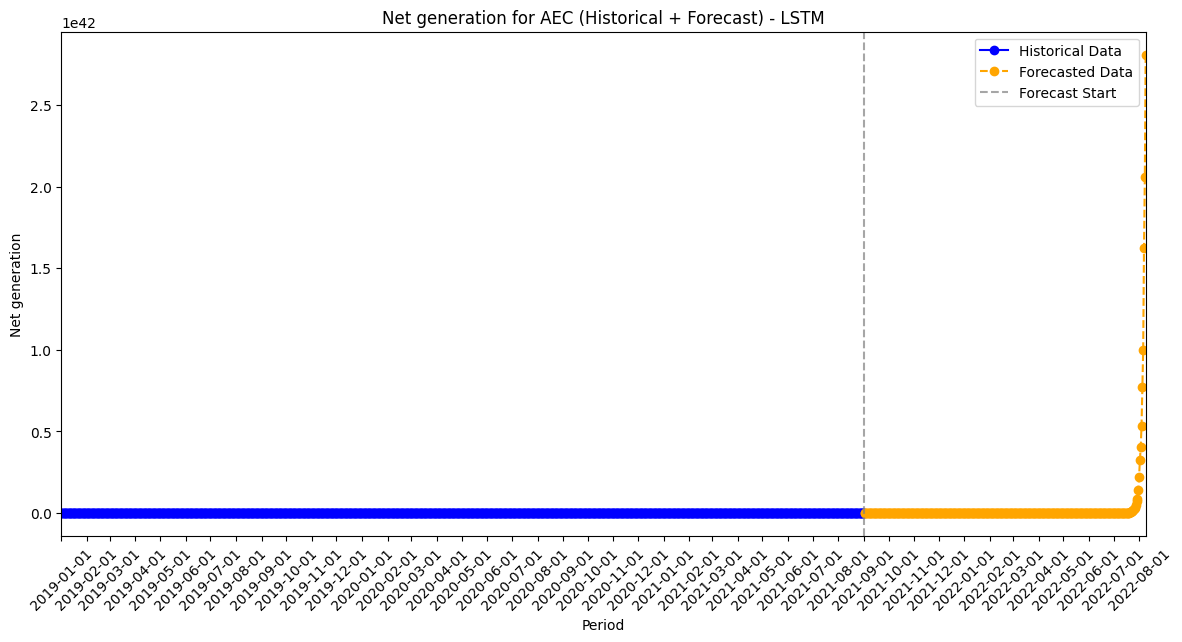

In [ ]:
# LSTM - Plotting
plot_lstm_demand_with_forecast(updated_df, selected_authority=selected_authority, selected_metric=selected_metric)

- Fastest Choice: For a quick baseline, ARIMA/SARIMA or exponential smoothing would be ideal, as they are fast to run and often perform well on simple time series with clear trends or seasonality.
- Balanced Speed and Performance: If you need a model that’s a bit more powerful without a massive runtime increase, XGBoost or Random Forest with lagged features and/or rolling statistics would be a good choice. They capture non-linear relationships while being moderately fast.
- For Complex Patterns: Use LSTMs or transformers if your time series has complex dependencies, but be prepared for longer training times.

For most practical purposes, XGBoost offers a good trade-off between speed and modeling flexibility, especially for data with non-linear patterns but without the very long training times of deep learning models.

Create a dataframe showing the RMSE for each model for each balancing authority and energy metric combination.

In [ ]:
# Load the trained LSTM models and associated data
with open("lstm_results.pkl", "rb") as f:
    lstm_results = pickle.load(f)

# Load the trained SARIMA models and associated data
with open("sarima_results.pkl", "rb") as f:
    sarima_results = pickle.load(f)

# Load the trained XGBoost models and associated data
with open("xgboost_results.pkl", "rb") as f:
    xgboost_results = pickle.load(f)

# Prepare a list to store rows for the DataFrame
data = []

# Extract respondents and type_names from the results
keys = set(
    list(sarima_results.keys()) +
    list(xgboost_results.keys()) +
    list(lstm_results.keys())
)

# Build the DataFrame row by row
for (respondent, type_name) in keys:
    # Get RMSE values, default to None if the model isn't available
    sarima_rmse = sarima_results.get((respondent, type_name), {}).get("rmse", None)
    xgboost_rmse = xgboost_results.get((respondent, type_name), {}).get("rmse", None)
    lstm_rmse = lstm_results.get((respondent, type_name), {}).get("rmse", None)

    # Calculate the best RMSE and determine the best model
    rmse_values = {
        "SARIMA": sarima_rmse,
        "XGBoost": xgboost_rmse,
        "LSTM": lstm_rmse
    }
    best_rmse = min([val for val in rmse_values.values() if val is not None], default=None)
    best_model = min(rmse_values, key=lambda k: rmse_values[k] if rmse_values[k] is not None else float('inf'))

    # Append the row to the list
    data.append({
        "respondent": respondent,
        "type_name": type_name,
        "sarima_rmse": sarima_rmse,
        "xgboost_rmse": xgboost_rmse,
        "lstm_rmse": lstm_rmse,
        "best_rmse": best_rmse,
        "best_model": best_model if best_rmse is not None else None
    })

# Create the DataFrame
rmse_df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
rmse_df.to_csv("rmse_comparison.csv", index=False)

# Display the DataFrame
print(rmse_df)

    respondent       type_name   sarima_rmse  xgboost_rmse      lstm_rmse  \
0          PJM  Net generation           NaN  84187.690124  102081.665260   
1          CAL  Net generation  67298.642807  43526.788899   46119.892672   
2         WAUW          Demand    266.299000    114.118778     117.316558   
3          SPA          Demand           NaN    242.179468     255.883229   
4         DEAA  Net generation   4024.675469   1811.748577    1951.030437   
..         ...             ...           ...           ...            ...   
134       LDWP  Net generation           NaN   9147.068293    7212.667120   
135       IPCO          Demand   4151.173042   2109.134165    2121.424910   
136       PSEI  Net generation   9381.877369   2553.965094    2558.037873   
137       GRIF  Net generation   4048.068889   2008.248550    2236.176126   
138       SCEG  Net generation           NaN   3978.266676    4377.145630   

        best_rmse best_model  
0    84187.690124    XGBoost  
1    43526.78

In [ ]:
# Load the CSV file
rmse_df = pd.read_csv("rmse_comparison.csv")

# Count the number of times each model performed best
best_model_counts = rmse_df['best_model'].value_counts()

# Count the number of NaN values for each model's RMSE
nan_counts = rmse_df[['sarima_rmse', 'xgboost_rmse', 'lstm_rmse']].isna().sum()

# Combine the results into a summary DataFrame
summary = pd.DataFrame({
    "model": ["SARIMA", "XGBoost", "LSTM"],
    "best_model_counts": [best_model_counts.get("SARIMA", 0),
                          best_model_counts.get("XGBoost", 0),
                          best_model_counts.get("LSTM", 0)],
    "nan_counts": [nan_counts['sarima_rmse'], nan_counts['xgboost_rmse'], nan_counts['lstm_rmse']]
})

# Save the summary to a CSV file
summary.to_csv("model_performance_summary.csv", index=False)

# Display the summary
print(summary)

     model  best_model_counts  nan_counts
0   SARIMA                  0          44
1  XGBoost                109           0
2     LSTM                 30           0


Updated List of Possible Causes for NaN values for SARIMA-X model:
- Grid Search Failure: SARIMA struggled to find valid parameters for some combinations.
- Frequency Issues: Irregular or undefined frequency caused SARIMA to fail.
- Model Fitting Exceptions: SARIMA encountered exceptions during optimization or fitting.
- Stationarity Issues: SARIMA required the series to be stationary, but this condition wasn't met.

- Create forecast for the last 20% of the historical data in order to be used later for visualization for comparison with actual data and day ahead forecasts.
- The day-ahead demand forecast is available for 69 balancing authorities.

XGBoost Forecasting of part of historical data.

In [ ]:
# Load XGBoost results
with open("xgboost_results.pkl", "rb") as f:
    xgboost_results = pickle.load(f)

# Prepare a DataFrame to store predictions and test values for all combinations
xgboost_forecast_df = []

# Iterate through the results to extract predictions, test values, and periods
for (respondent, metric), result in xgboost_results.items():
    predictions = result.get("predictions", None)
    y_test = result.get("y_test", None)

    if predictions is not None and y_test is not None:
        # Filter the daily_demand_df for the specific respondent and type_name
        filtered_df = daily_demand_df[
            (daily_demand_df['respondent'] == respondent) &
            (daily_demand_df['type_name'] == metric)
        ].sort_values('period')
        
        # Get the last 20% of rows
        test_periods = filtered_df['period'].iloc[-len(y_test):].values
        
        # Create a DataFrame for this combination
        df = pd.DataFrame({
            "respondent": respondent,
            "type_name": metric,
            "period": test_periods,
            "y_test": y_test,
            "y_pred": predictions
        })
        xgboost_forecast_df.append(df)

# Combine all individual DataFrames into one
xgboost_forecast_df = pd.concat(xgboost_forecast_df, ignore_index=True)

# Save the DataFrame to a CSV file for inspection
xgboost_forecast_df.to_csv("xgboost_forecast_test_data.csv", index=False)

# Display the DataFrame
print(xgboost_forecast_df)

      respondent       type_name      period   y_test        y_pred
0            AEC          Demand  2021-02-20  16320.0  17204.220703
1            AEC          Demand  2021-02-21  14474.0  14891.513672
2            AEC          Demand  2021-02-22  11000.0  12583.160156
3            AEC          Demand  2021-02-23  12374.0  12129.691406
4            AEC          Demand  2021-02-24  12353.0  11891.824219
...          ...             ...         ...      ...           ...
57311        YAD  Net generation  2024-11-03    756.0    744.140747
57312        YAD  Net generation  2024-11-04   1363.0   1223.382202
57313        YAD  Net generation  2024-11-05   1250.0   1584.134155
57314        YAD  Net generation  2024-11-06   2238.0   1745.874512
57315        YAD  Net generation  2024-11-07   2358.0   2818.612061

[57316 rows x 5 columns]


SARIMA-X Forecasting of part of historical data.

In [ ]:
# Load SARIMA results
with open("sarima_results.pkl", "rb") as f:
    sarima_results = pickle.load(f)

# Prepare a DataFrame to store predictions and test values for all combinations
sarima_forecast_df = []

# Iterate through the results to extract predictions and test values
for (respondent, metric), result in sarima_results.items():
    best_model = result.get("model", None)
    exog = result.get("exog", None)

    if best_model is not None and exog is not None:
        # Filter the daily_demand_df for the specific respondent and type_name
        filtered_df = daily_demand_df[
            (daily_demand_df['respondent'] == respondent) &
            (daily_demand_df['type_name'] == metric)
        ].sort_values('period')

        # Extract the last 20% of rows as the test period
        num_test_rows = int(len(filtered_df) * 0.2)
        test_data = filtered_df.iloc[-num_test_rows:]
        y_test = test_data['value'].values
        exog_test = exog.iloc[-num_test_rows:]

        # Generate predictions using the SARIMA-X model
        predictions = best_model.get_forecast(steps=len(y_test), exog=exog_test).predicted_mean

        # Create a DataFrame for this combination
        df = pd.DataFrame({
            "respondent": respondent,
            "type_name": metric,
            "period": test_data['period'].values,
            "y_test": y_test,
            "y_pred": predictions
        })
        sarima_forecast_df.append(df)

# Combine all individual DataFrames into one
sarima_forecast_df = pd.concat(sarima_forecast_df, ignore_index=True)

# Save the DataFrame to a CSV file for inspection
sarima_forecast_df.to_csv("sarima_forecast_test_data.csv", index=False)

# Display the DataFrame
print(sarima_forecast_df)

      respondent       type_name      period   y_test       y_pred
0            AEC          Demand  2021-02-19  16289.0  1028.536739
1            AEC          Demand  2021-02-20  16320.0  3667.191064
2            AEC          Demand  2021-02-21  14474.0  5718.809508
3            AEC          Demand  2021-02-22  11000.0  7513.573123
4            AEC          Demand  2021-02-23  12374.0  8782.857566
...          ...             ...         ...      ...          ...
39397       WAUW  Net generation  2024-11-03     98.0  1249.649315
39398       WAUW  Net generation  2024-11-04     95.0  1203.953515
39399       WAUW  Net generation  2024-11-05    481.0  1175.236066
39400       WAUW  Net generation  2024-11-06   1386.0  1208.360523
39401       WAUW  Net generation  2024-11-07   1390.0  1246.598082

[39402 rows x 5 columns]


LSTM Forecasting of part of historical data.

In [ ]:
# Load LSTM results
with open("lstm_results.pkl", "rb") as f:
    lstm_results = pickle.load(f)

# Prepare a DataFrame to store predictions and test values for all combinations
lstm_forecast_df = []

# Iterate through the results to extract predictions and test values
for (respondent, metric), result in lstm_results.items():
    y_test = result.get("y_test", None)
    y_pred = result.get("predictions", None)

    if y_test is not None and y_pred is not None:
        # Filter the daily_demand_df for the specific respondent and type_name
        filtered_df = daily_demand_df[
            (daily_demand_df['respondent'] == respondent) &
            (daily_demand_df['type_name'] == metric)
        ].sort_values('period')

        # Extract the last 20% of rows as the test period
        num_test_rows = len(y_test)
        test_periods = filtered_df['period'].iloc[-num_test_rows:].values

        # Create a DataFrame for this combination
        df = pd.DataFrame({
            "respondent": respondent,
            "type_name": metric,
            "period": test_periods,
            "y_test": y_test,
            "y_pred": y_pred
        })
        lstm_forecast_df.append(df)

# Combine all individual DataFrames into one
lstm_forecast_df = pd.concat(lstm_forecast_df, ignore_index=True)

# Save the DataFrame to a CSV file for inspection
lstm_forecast_df.to_csv("lstm_forecast_test_data.csv", index=False)

# Display the DataFrame
print(lstm_forecast_df)

      respondent       type_name      period   y_test        y_pred
0            AEC          Demand  2021-02-21  14474.0  16038.229492
1            AEC          Demand  2021-02-22  11000.0  15614.086914
2            AEC          Demand  2021-02-23  12374.0  13644.761719
3            AEC          Demand  2021-02-24  12353.0  13345.609375
4            AEC          Demand  2021-02-25  10726.0  13117.875000
...          ...             ...         ...      ...           ...
57206        YAD  Net generation  2024-11-03    756.0    961.037109
57207        YAD  Net generation  2024-11-04   1363.0    953.848633
57208        YAD  Net generation  2024-11-05   1250.0   1407.230591
57209        YAD  Net generation  2024-11-06   2238.0   1305.295044
57210        YAD  Net generation  2024-11-07   2358.0   2069.343018

[57211 rows x 5 columns]


Combining historical data from daily_demand_df dataframe taken from daily_demand SQL table and the forecasted data for the last 20% of history for each model.

In [ ]:
# Load the test CSV and the main DataFrame
sarima_forecast_test_data = pd.read_csv("sarima_forecast_test_data.csv")

# Create a copy of the daily_demand_df to ensure the original DataFrame is not modified
daily_demand_copy = daily_demand_df.copy()

# Convert 'period' column to datetime for proper filtering and sorting
sarima_forecast_test_data['period'] = pd.to_datetime(sarima_forecast_test_data['period'])
daily_demand_copy['period'] = pd.to_datetime(daily_demand_copy['period'])

# Initialize an empty list to collect rows for the new CSV
history_forecast_data = []

# Loop through each unique (respondent, type_name) tuple
for (respondent, type_name), group in sarima_forecast_test_data.groupby(['respondent', 'type_name']):
    # Get the earliest date in the test data for this respondent/type_name tuple
    first_test_date = group['period'].min()
    
    # Filter the copied DataFrame for rows before this date and for the same respondent/type_name tuple
    history_rows = daily_demand_copy[
        (daily_demand_copy['respondent'] == respondent) & 
        (daily_demand_copy['type_name'] == type_name) & 
        (daily_demand_copy['period'] < first_test_date)
    ]
    
    # Create rows for the 80% data: populate y_test with 'value' and y_pred with NaN
    for _, row in history_rows.iterrows():
        history_forecast_data.append({
            'respondent': row['respondent'],
            'type_name': row['type_name'],
            'period': row['period'],
            'y_test': row['value'],
            'y_pred': np.nan
        })
    
    # Append the 20% test data for the same respondent/type_name
    for _, row in group.iterrows():
        history_forecast_data.append({
            'respondent': row['respondent'],
            'type_name': row['type_name'],
            'period': row['period'],
            'y_test': row['y_test'],
            'y_pred': row['y_pred']
        })

# Create a DataFrame from the combined data
sarima_history_forecast = pd.DataFrame(history_forecast_data)

# Sort the combined data by respondent, type_name, and period
sarima_history_forecast = sarima_history_forecast.sort_values(by=['respondent', 'type_name', 'period']).reset_index(drop=True)

# Save the new DataFrame to a CSV file
sarima_history_forecast.to_csv("sarima_history_forecast.csv", index=False)

print("sarima_history_forecast.csv has been created successfully.")

sarima_history_forecast.csv has been created successfully.


In [ ]:
# Load the necessary files
sarima_history_forecast = pd.read_csv("sarima_history_forecast.csv")

# Convert 'period' columns to datetime for proper merging and sorting
sarima_history_forecast['period'] = pd.to_datetime(sarima_history_forecast['period'])
daily_demand_df['period'] = pd.to_datetime(daily_demand_df['period'])

# Extract 'Day-ahead demand forecast' from the daily_demand_df
day_ahead_forecast = daily_demand_df[daily_demand_df['type_name'] == "Day-ahead demand forecast"]

# Shift the Day-ahead demand forecast by one row for each respondent
day_ahead_forecast = (
    day_ahead_forecast
    .sort_values(by=['respondent', 'period'])  # Sort to ensure proper shifting
    .assign(shifted_forecast=lambda x: x['value'].shift(1))  # Shift the value
)

# Keep only relevant columns for merging
day_ahead_forecast = day_ahead_forecast[['respondent', 'period', 'shifted_forecast']]

# Merge the shifted Day-ahead demand forecast into the SARIMA history forecast
sarima_history_forecast = sarima_history_forecast.merge(
    day_ahead_forecast,
    on=['respondent', 'period'],
    how='left'
)

# Rename the new column to 'Day-ahead demand forecast'
sarima_history_forecast.rename(columns={'shifted_forecast': 'Day-ahead demand forecast'}, inplace=True)

# Save the updated DataFrame to a new CSV file
sarima_history_forecast.to_csv("sarima_history_forecast_with_day_ahead.csv", index=False)

print("Day-ahead demand forecast added and saved as 'sarima_history_forecast_with_day_ahead.csv'.")

Day-ahead demand forecast added and saved as 'sarima_history_forecast_with_day_ahead.csv'.


In [ ]:
# Load the test CSV and the main DataFrame
xgboost_forecast_test_data = pd.read_csv("xgboost_forecast_test_data.csv")

# Create a copy of the daily_demand_df to ensure the original DataFrame is not modified
daily_demand_copy = daily_demand_df.copy()

# Convert 'period' column to datetime for proper filtering and sorting
xgboost_forecast_test_data['period'] = pd.to_datetime(xgboost_forecast_test_data['period'])
daily_demand_copy['period'] = pd.to_datetime(daily_demand_copy['period'])

# Initialize an empty list to collect rows for the new CSV
history_forecast_data = []

# Loop through each unique (respondent, type_name) tuple
for (respondent, type_name), group in xgboost_forecast_test_data.groupby(['respondent', 'type_name']):
    # Get the earliest date in the test data for this respondent/type_name tuple
    first_test_date = group['period'].min()
    
    # Filter the copied DataFrame for rows before this date and for the same respondent/type_name tuple
    history_rows = daily_demand_copy[
        (daily_demand_copy['respondent'] == respondent) & 
        (daily_demand_copy['type_name'] == type_name) & 
        (daily_demand_copy['period'] < first_test_date)
    ]
    
    # Create rows for the 80% data: populate y_test with 'value' and y_pred with NaN
    for _, row in history_rows.iterrows():
        history_forecast_data.append({
            'respondent': row['respondent'],
            'type_name': row['type_name'],
            'period': row['period'],
            'y_test': row['value'],
            'y_pred': np.nan
        })
    
    # Append the 20% test data for the same respondent/type_name
    for _, row in group.iterrows():
        history_forecast_data.append({
            'respondent': row['respondent'],
            'type_name': row['type_name'],
            'period': row['period'],
            'y_test': row['y_test'],
            'y_pred': row['y_pred']
        })

# Create a DataFrame from the combined data
xgboost_history_forecast = pd.DataFrame(history_forecast_data)

# Sort the combined data by respondent, type_name, and period
xgboost_history_forecast = xgboost_history_forecast.sort_values(by=['respondent', 'type_name', 'period']).reset_index(drop=True)

# Save the new DataFrame to a CSV file
xgboost_history_forecast.to_csv("xgboost_history_forecast.csv", index=False)

print("xgboost_history_forecast.csv has been created successfully.")

xgboost_history_forecast.csv has been created successfully.


In [ ]:
# Load the XGBoost history forecast data and daily demand data
xgboost_history_forecast = pd.read_csv("xgboost_history_forecast.csv")

# Ensure the 'period' column is in datetime format for proper merging and sorting
xgboost_history_forecast['period'] = pd.to_datetime(xgboost_history_forecast['period'])
daily_demand_df['period'] = pd.to_datetime(daily_demand_df['period'])

# Extract 'Day-ahead demand forecast' from the daily_demand_df
day_ahead_forecast = daily_demand_df[daily_demand_df['type_name'] == "Day-ahead demand forecast"]

# Shift the Day-ahead demand forecast by one row for each respondent
day_ahead_forecast = (
    day_ahead_forecast
    .sort_values(by=['respondent', 'period'])  # Ensure proper order for shifting
    .assign(shifted_forecast=lambda x: x['value'].shift(1))  # Shift the 'value' column
)

# Keep only the relevant columns for merging
day_ahead_forecast = day_ahead_forecast[['respondent', 'period', 'shifted_forecast']]

# Merge the shifted Day-ahead demand forecast into the XGBoost history forecast DataFrame
xgboost_history_forecast = xgboost_history_forecast.merge(
    day_ahead_forecast,
    on=['respondent', 'period'],
    how='left'
)

# Rename the merged column to 'Day-ahead demand forecast'
xgboost_history_forecast.rename(columns={'shifted_forecast': 'Day-ahead demand forecast'}, inplace=True)

# Save the updated DataFrame to a new CSV file
xgboost_history_forecast.to_csv("xgboost_history_forecast_with_day_ahead.csv", index=False)

print("Day-ahead demand forecast added and saved as 'xgboost_history_forecast_with_day_ahead.csv'.")

Day-ahead demand forecast added and saved as 'xgboost_history_forecast_with_day_ahead.csv'.


In [ ]:
# Load the test CSV and the main DataFrame
lstm_forecast_test_data = pd.read_csv("lstm_forecast_test_data.csv")

# Create a copy of the daily_demand_df to ensure the original DataFrame is not modified
daily_demand_copy = daily_demand_df.copy()

# Convert 'period' column to datetime for proper filtering and sorting
lstm_forecast_test_data['period'] = pd.to_datetime(lstm_forecast_test_data['period'])
daily_demand_copy['period'] = pd.to_datetime(daily_demand_copy['period'])

# Initialize an empty list to collect rows for the new CSV
history_forecast_data = []

# Loop through each unique (respondent, type_name) tuple
for (respondent, type_name), group in lstm_forecast_test_data.groupby(['respondent', 'type_name']):
    # Get the earliest date in the test data for this respondent/type_name tuple
    first_test_date = group['period'].min()
    
    # Filter the copied DataFrame for rows before this date and for the same respondent/type_name tuple
    history_rows = daily_demand_copy[
        (daily_demand_copy['respondent'] == respondent) & 
        (daily_demand_copy['type_name'] == type_name) & 
        (daily_demand_copy['period'] < first_test_date)
    ]
    
    # Create rows for the 80% data: populate y_test with 'value' and y_pred with NaN
    for _, row in history_rows.iterrows():
        history_forecast_data.append({
            'respondent': row['respondent'],
            'type_name': row['type_name'],
            'period': row['period'],
            'y_test': row['value'],
            'y_pred': np.nan
        })
    
    # Append the 20% test data for the same respondent/type_name
    for _, row in group.iterrows():
        history_forecast_data.append({
            'respondent': row['respondent'],
            'type_name': row['type_name'],
            'period': row['period'],
            'y_test': row['y_test'],
            'y_pred': row['y_pred']
        })

# Create a DataFrame from the combined data
lstm_history_forecast = pd.DataFrame(history_forecast_data)

# Sort the combined data by respondent, type_name, and period
lstm_history_forecast = lstm_history_forecast.sort_values(by=['respondent', 'type_name', 'period']).reset_index(drop=True)

# Save the new DataFrame to a CSV file
lstm_history_forecast.to_csv("lstm_history_forecast.csv", index=False)

print("lstm_history_forecast.csv has been created successfully.")

In [ ]:
# Load the necessary files
lstm_history_forecast = pd.read_csv("lstm_history_forecast.csv")

# Convert 'period' columns to datetime for proper merging and sorting
lstm_history_forecast['period'] = pd.to_datetime(lstm_history_forecast['period'])
daily_demand_df['period'] = pd.to_datetime(daily_demand_df['period'])

# Extract 'Day-ahead demand forecast' from the daily_demand_df
day_ahead_forecast = daily_demand_df[daily_demand_df['type_name'] == "Day-ahead demand forecast"]

# Shift the Day-ahead demand forecast by one row for each respondent
day_ahead_forecast = (
    day_ahead_forecast
    .sort_values(by=['respondent', 'period'])  # Sort to ensure proper shifting
    .assign(shifted_forecast=lambda x: x['value'].shift(1))  # Shift the value
)

# Keep only relevant columns for merging
day_ahead_forecast = day_ahead_forecast[['respondent', 'period', 'shifted_forecast']]

# Merge the shifted Day-ahead demand forecast into the LSTM history forecast
lstm_history_forecast = lstm_history_forecast.merge(
    day_ahead_forecast,
    on=['respondent', 'period'],
    how='left'
)

# Rename the new column to 'Day-ahead demand forecast'
lstm_history_forecast.rename(columns={'shifted_forecast': 'Day-ahead demand forecast'}, inplace=True)

# Save the updated DataFrame to a new CSV file
lstm_history_forecast.to_csv("lstm_history_forecast_with_day_ahead.csv", index=False)

print("Day-ahead demand forecast added and saved as 'lstm_history_forecast_with_day_ahead.csv'.")

Day-ahead demand forecast added and saved as 'lstm_history_forecast_with_day_ahead.csv'.


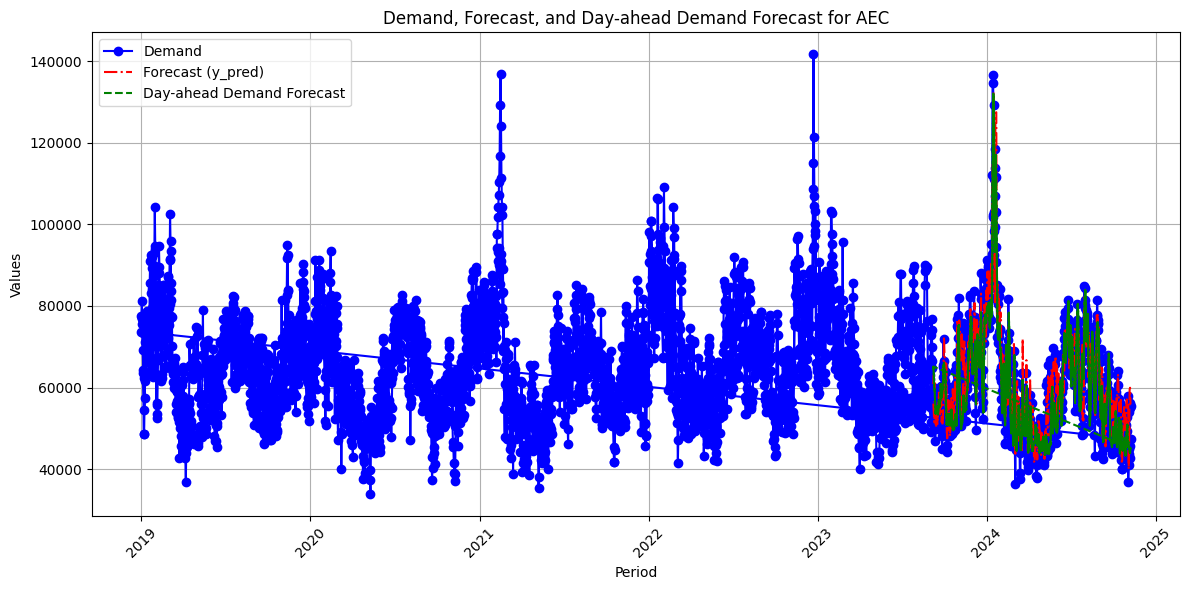

In [ ]:
# Load the data
data = pd.read_csv("xgboost_history_forecast_with_day_ahead.csv")

# Convert 'period' column to datetime
data['period'] = pd.to_datetime(data['period'])

# Filter the data for respondent 'AEC'
selected_data = data[data['respondent'] == selected_authority]

# Identify the time range for y_pred (forecast)
forecast_period = selected_data[selected_data['y_pred'].notna()]['period']

# Mask for the day-ahead demand forecast to match the forecast period
mask_day_ahead = selected_data['period'].isin(forecast_period)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot the demand for the entire period
plt.plot(selected_data['period'], selected_data['y_test'], label='Demand', color='blue', marker='o')

# Plot the forecast (y_pred)
plt.plot(selected_data['period'], selected_data['y_pred'], label='Forecast (y_pred)', color='red', linestyle='-.')

# Plot the day-ahead demand forecast for the same period as the forecast
plt.plot(selected_data[mask_day_ahead]['period'], 
         selected_data[mask_day_ahead]['Day-ahead demand forecast'], 
         label='Day-ahead Demand Forecast', color='green', linestyle='--')

# Add labels, title, and legend
plt.xlabel('Period')
plt.ylabel('Values')
plt.title('Demand, Forecast, and Day-ahead Demand Forecast for AEC')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
# Load the rmse_comparison.csv file
rmse_comparison = pd.read_csv("rmse_comparison.csv")

# Pivot the DataFrame to get the desired summary format
summary_df = rmse_comparison.pivot_table(
    index="respondent", 
    columns="type_name", 
    values="best_model", 
    aggfunc="first"
).reset_index()

# Rename the columns for clarity
summary_df.columns.name = None  # Remove the index name
summary_df.rename(columns={"Demand": "demand", "Net generation": "net generation"}, inplace=True)

# Save the summarized DataFrame to a new CSV file
summary_df.to_csv("rmse_comparison_summary_best_model.csv", index=False)

# Display the resulting DataFrame
print(summary_df)


   respondent   demand net generation
0         AEC  XGBoost           LSTM
1        AECI     LSTM        XGBoost
2         AVA  XGBoost        XGBoost
3        AVRN      NaN        XGBoost
4        AZPS     LSTM        XGBoost
..        ...      ...            ...
70       WACM     LSTM        XGBoost
71       WALC  XGBoost        XGBoost
72       WAUW  XGBoost        XGBoost
73        WWA      NaN        XGBoost
74        YAD      NaN        XGBoost

[75 rows x 3 columns]


In [ ]:
# Load the CSV files
sarima_complete_df = pd.read_csv("sarima_complete_df.csv")

# Strip whitespace from the 'period' column
sarima_complete_df['period'] = sarima_complete_df['period'].str.strip()

# Convert 'period' column to datetime and normalize
sarima_complete_df['period'] = pd.to_datetime(sarima_complete_df['period'], errors='coerce').dt.normalize()

# Check for rows where 'period' is NaT after conversion
invalid_periods = sarima_complete_df[sarima_complete_df['period'].isna()]
if not invalid_periods.empty:
    print("Warning: The following rows in sarima_complete_df have invalid 'period' values and will be dropped:")
    print(invalid_periods)

# Drop rows with invalid 'period' values
sarima_complete_df = sarima_complete_df.dropna(subset=['period'])

# Display the cleaned DataFrame
print(sarima_complete_df.head())


       period respondent       type_name         value  forecast
615706    NaT        AEC          Demand   4267.051602  forecast
615707    NaT        AEC          Demand   7047.219955  forecast
615708    NaT        AEC          Demand   8857.966372  forecast
615709    NaT        AEC          Demand  10202.424963  forecast
615710    NaT        AEC          Demand  11289.670795  forecast
...       ...        ...             ...           ...       ...
650011    NaT       WAUW  Net generation   1249.649315  forecast
650012    NaT       WAUW  Net generation   1203.953515  forecast
650013    NaT       WAUW  Net generation   1175.236066  forecast
650014    NaT       WAUW  Net generation   1208.360523  forecast
650015    NaT       WAUW  Net generation   1246.598082  forecast

[34310 rows x 5 columns]
      period respondent          type_name    value forecast
0 2019-01-01        AEC             Demand   9721.0  history
1 2019-01-01        AEC     Net generation   9858.0  history
2 2019-01-0

In [ ]:
# Load the CSV files
sarima_complete_df = pd.read_csv("sarima_complete_df.csv")
sarima_history_forecast = pd.read_csv("sarima_history_forecast_with_day_ahead.csv")

# Strip whitespace from all string columns in both DataFrames
sarima_complete_df = sarima_complete_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
sarima_history_forecast = sarima_history_forecast.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Filter rows where 'forecast' column is 'forecast'
forecast_points = sarima_complete_df[sarima_complete_df['forecast'] == 'forecast']

# Create a copy of the history forecast to modify
new_sarima_history_forecast = sarima_history_forecast.copy()

# Loop through each unique (respondent, type_name) combination
for (respondent, type_name), group in forecast_points.groupby(['respondent', 'type_name']):
    # Get the periods and values for the current combination
    periods = group['period']
    values = group['value']
    
    # Create a DataFrame for the extrapolated rows
    extrapolated_rows = pd.DataFrame({
        'respondent': respondent,
        'type_name': type_name,
        'period': periods,  # Leave 'period' as strings
        'y_test': pd.NA,  # Blank (NaN) for 'y_test'
        'y_pred': values,  # 'value' column mapped to 'y_pred'
        'Day-ahead demand forecast': pd.NA  # Blank (NaN) for 'Day-ahead demand forecast'
    })
    
    # Append the extrapolated rows to the history forecast DataFrame
    new_sarima_history_forecast = pd.concat([new_sarima_history_forecast, extrapolated_rows], ignore_index=True)

# Sort by respondent, type_name, and period for consistency
new_sarima_history_forecast = new_sarima_history_forecast.sort_values(by=['respondent', 'type_name', 'period']).reset_index(drop=True)

# Save the resulting DataFrame to a new CSV file
new_sarima_history_forecast.to_csv("sarima_history_forecast_with_extrapolated.csv", index=False)

print("New CSV file 'sarima_history_forecast_with_extrapolated.csv' created successfully.")

New CSV file 'sarima_history_forecast_with_extrapolated.csv' created successfully.


In [ ]:
# Load the CSV files
xgboost_complete_df = pd.read_csv("xgboost_complete_df.csv")
xgboost_history_forecast = pd.read_csv("xgboost_history_forecast_with_day_ahead.csv")

# Strip whitespace from all string columns in both DataFrames
xgboost_complete_df = xgboost_complete_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
xgboost_history_forecast = xgboost_history_forecast.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Filter rows where 'forecast' column is 'forecast'
forecast_points = xgboost_complete_df[xgboost_complete_df['forecast'] == 'forecast']

# Create a copy of the history forecast to modify
new_xgboost_history_forecast = xgboost_history_forecast.copy()

# Loop through each unique (respondent, type_name) combination
for (respondent, type_name), group in forecast_points.groupby(['respondent', 'type_name']):
    # Get the periods and values for the current combination
    periods = group['period']
    values = group['value']
    
    # Create a DataFrame for the extrapolated rows
    extrapolated_rows = pd.DataFrame({
        'respondent': respondent,
        'type_name': type_name,
        'period': periods,  # Leave 'period' as strings
        'y_test': pd.NA,  # Blank (NaN) for 'y_test'
        'y_pred': values,  # 'value' column mapped to 'y_pred'
        'Day-ahead demand forecast': pd.NA  # Blank (NaN) for 'Day-ahead demand forecast'
    })
    
    # Append the extrapolated rows to the history forecast DataFrame
    new_xgboost_history_forecast = pd.concat([new_xgboost_history_forecast, extrapolated_rows], ignore_index=True)

# Sort by respondent, type_name, and period for consistency
new_xgboost_history_forecast = new_xgboost_history_forecast.sort_values(by=['respondent', 'type_name', 'period']).reset_index(drop=True)

# Save the resulting DataFrame to a new CSV file
new_xgboost_history_forecast.to_csv("xgboost_history_forecast_with_extrapolated.csv", index=False)

print("New CSV file 'xgboost_history_forecast_with_extrapolated.csv' created successfully.")

New CSV file 'xgboost_history_forecast_with_extrapolated.csv' created successfully.


In [ ]:
# Load the CSV files
lstm_complete_df = pd.read_csv("lstm_complete_df.csv")
lstm_history_forecast = pd.read_csv("lstm_history_forecast_with_day_ahead.csv")

# Strip whitespace from all string columns in both DataFrames
lstm_complete_df = lstm_complete_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
lstm_history_forecast = lstm_history_forecast.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Filter rows where 'forecast' column is 'forecast'
forecast_points = lstm_complete_df[lstm_complete_df['forecast'] == 'forecast']

# Create a copy of the history forecast to modify
new_lstm_history_forecast = lstm_history_forecast.copy()

# Loop through each unique (respondent, type_name) combination
for (respondent, type_name), group in forecast_points.groupby(['respondent', 'type_name']):
    # Get the periods and values for the current combination
    periods = group['period']
    values = group['value']
    
    # Create a DataFrame for the extrapolated rows
    extrapolated_rows = pd.DataFrame({
        'respondent': respondent,
        'type_name': type_name,
        'period': periods,  # Leave 'period' as strings
        'y_test': pd.NA,  # Blank (NaN) for 'y_test'
        'y_pred': values,  # 'value' column mapped to 'y_pred'
        'Day-ahead demand forecast': pd.NA  # Blank (NaN) for 'Day-ahead demand forecast'
    })
    
    # Append the extrapolated rows to the history forecast DataFrame
    new_lstm_history_forecast = pd.concat([new_lstm_history_forecast, extrapolated_rows], ignore_index=True)

# Sort by respondent, type_name, and period for consistency
new_lstm_history_forecast = new_lstm_history_forecast.sort_values(by=['respondent', 'type_name', 'period']).reset_index(drop=True)

# Save the resulting DataFrame to a new CSV file
new_lstm_history_forecast.to_csv("lstm_history_forecast_with_extrapolated.csv", index=False)

print("New CSV file 'lstm_history_forecast_with_extrapolated.csv' created successfully.")

New CSV file 'lstm_history_forecast_with_extrapolated.csv' created successfully.


In [ ]:
# Load the three CSV files
lstm_df = pd.read_csv("lstm_history_forecast_with_extrapolated.csv")
sarima_df = pd.read_csv("sarima_history_forecast_with_extrapolated.csv")
xgboost_df = pd.read_csv("xgboost_history_forecast_with_extrapolated.csv")

# Rename the 'y_pred' column in each DataFrame to include the model name
lstm_df.rename(columns={'y_pred': 'y_pred_lstm', 'y_test': 'actuals'}, inplace=True)
sarima_df.rename(columns={'y_pred': 'y_pred_sarima', 'y_test': 'actuals'}, inplace=True)
xgboost_df.rename(columns={'y_pred': 'y_pred_xgboost', 'y_test': 'actuals'}, inplace=True)

# Merge the three DataFrames on the shared columns
merged_df = pd.merge(lstm_df, sarima_df[['respondent', 'type_name', 'period', 'y_pred_sarima']],
                     on=['respondent', 'type_name', 'period'], how='outer')

merged_df = pd.merge(merged_df, xgboost_df[['respondent', 'type_name', 'period', 'y_pred_xgboost']],
                     on=['respondent', 'type_name', 'period'], how='outer')

# Save the merged DataFrame to a new CSV file
merged_df.to_csv("merged_predictions.csv", index=False)

print("Merged CSV file 'merged_predictions.csv' created successfully.")

Merged CSV file 'merged_predictions.csv' created successfully.


In [ ]:
# Load the main table and the best model summary table
main_table = pd.read_csv("merged_predictions.csv")
best_model_table = pd.read_csv("rmse_comparison_summary_best_model.csv")

# Melt the best model table to align it with type_name in the main table
best_model_table_melted = best_model_table.melt(id_vars=["respondent"], 
                                                var_name="type_name", 
                                                value_name="best_model")
# Map type_name in the melted table to match the main table's `type_name` values
best_model_table_melted["type_name"] = best_model_table_melted["type_name"].replace({
    "demand": "Demand", 
    "net generation": "Net generation"
})

# Merge the best model column into the main table
enhanced_table = pd.merge(
    main_table, 
    best_model_table_melted, 
    on=["respondent", "type_name"], 
    how="left"
)

# Save the enhanced table to a new CSV file
enhanced_table.to_csv("merged_predictions_v2.csv", index=False)

print("Enhanced table with best model added and saved as 'merged_predictions_v2.csv'.")

Enhanced table with best model added and saved as 'enhanced_predictions_with_best_model.csv'.


In [ ]:
# Load the enhanced table with the best_model column
enhanced_table = pd.read_csv("merged_predictions_v2.csv")

# Create a new column to store the best prediction based on the best_model column
enhanced_table['best_prediction'] = enhanced_table.apply(
    lambda row: row['y_pred_xgboost'] if row['best_model'] == 'XGBoost' else (
        row['y_pred_lstm'] if row['best_model'] == 'LSTM' else (
            row['y_pred_sarima'] if row['best_model'] == 'SARIMA' else None
        )
    ),
    axis=1
)

# Save the updated table to a new CSV file
enhanced_table.to_csv("merged_predictions_v3.csv", index=False)

print("Table updated with 'best_prediction' column and saved as 'enhanced_predictions_with_best_prediction.csv'.")

Table updated with 'best_prediction' column and saved as 'enhanced_predictions_with_best_prediction.csv'.


In [ ]:
# Load the enhanced table with the best_model column
enhanced_table = pd.read_csv("merged_predictions_v3.csv")

# Drop the columns for the three models' predictions
columns_to_drop = ['y_pred_xgboost', 'y_pred_lstm', 'y_pred_sarima','best_model']
enhanced_table_final = enhanced_table.drop(columns=columns_to_drop)

# Save the final table to a new CSV file
enhanced_table_final.to_csv("merged_predictions_final.csv", index=False)

print("Final table saved as 'merged_predictions_final.csv' with only the 'best_prediction' column retained.")

Final table saved as 'merged_predictions_final.csv' with only the 'best_prediction' column retained.


In [ ]:
# Load the CSV file into a DataFrame
file_path = 'merged_predictions_final.csv'
df = pd.read_csv(file_path)

# Ensure the 'best_prediction' column is numeric
df['best_prediction'] = pd.to_numeric(df['best_prediction'], errors='coerce')

# Filter rows where 'best_prediction' value is higher than 1 million
df_high_predictions = df[df['best_prediction'] > 2_000_000]

# Display the filtered rows
print(df_high_predictions)

len(df_high_predictions)

df_high_predictions['respondent'].unique()

# Count the number of NaN values in the 'actuals' column
num_nan_actuals = df_high_predictions['actuals'].isna().sum()

# Display the count
print(f"Number of NaN values in 'actuals' column: {num_nan_actuals}")

       respondent       type_name               period  actuals  \
88170        ERCO  Net generation  2025-05-23 00:00:00      NaN   
88171        ERCO  Net generation  2025-05-24 00:00:00      NaN   
88172        ERCO  Net generation  2025-05-25 00:00:00      NaN   
88173        ERCO  Net generation  2025-05-26 00:00:00      NaN   
88174        ERCO  Net generation  2025-05-27 00:00:00      NaN   
...           ...             ...                  ...      ...   
230707        PJM  Net generation  2025-11-03 00:00:00      NaN   
230708        PJM  Net generation  2025-11-04 00:00:00      NaN   
230709        PJM  Net generation  2025-11-05 00:00:00      NaN   
230710        PJM  Net generation  2025-11-06 00:00:00      NaN   
230711        PJM  Net generation  2025-11-07 00:00:00      NaN   

        Day-ahead demand forecast  best_prediction  
88170                         NaN     2.002267e+06  
88171                         NaN     2.014194e+06  
88172                         NaN   

In [ ]:
# Save the filtered DataFrame to a CSV file
df_high_predictions.to_csv('df_high_predictions.csv', index=False)

print("File saved successfully!")

File saved successfully!


PAGE RANK IMPLEMENTATION

Load the daily interchange table from the SQL database and remove the double counted edges between balancing authorities.

In [4]:
# Query the table and load data into a DataFrame
query = "SELECT * FROM daily_interchange"
daily_interchange_df = pd.read_sql(query, engine)

# Display first few rows of the DataFrame
print(daily_interchange_df.head())

       period fromba                            fromba_name  toba  \
0  2024-11-05   AECI  Associated Electric Cooperative, Inc.  MISO   
1  2024-11-05   AECI  Associated Electric Cooperative, Inc.   SPA   
2  2024-11-05   AECI  Associated Electric Cooperative, Inc.  SWPP   
3  2024-11-05   AECI  Associated Electric Cooperative, Inc.   TVA   
4  2024-11-05    AVA                     Avista Corporation  BPAT   

                                        toba_name timezone    value  \
0  Midcontinent Independent System Operator, Inc.  Eastern  17247.0   
1               Southwestern Power Administration  Eastern    -25.0   
2                            Southwest Power Pool  Eastern  -3541.0   
3                      Tennessee Valley Authority  Eastern      0.0   
4                 Bonneville Power Administration  Eastern -18530.0   

     value_units  
0  megawatthours  
1  megawatthours  
2  megawatthours  
3  megawatthours  
4  megawatthours  


Filtering the dataframe for balancing authorities which are present in the daily demand dataframe. Moreover, removing regions as they encompass each balancing authority and are not standalone entities.

In [5]:
authority_options = [
    "AEC", "AECI", "AVA", "AVRN", "AZPS", "BANC", "BPAT", "CHPD", "CISO", "CPLE", "CPLW", "DEAA", "DOPD", "DUK",
    "EEI", "EPE", "ERCO", "FMPP", "FPC", "FPL", "GCPD", "GLHB", "GRID", "GRIF", "GVL", "GWA", "HGMA", "HST", "IID",
    "IPCO", "ISNE", "JEA", "LDWP", "LGEE", "MISO", "NEVP", "NSB", "NWMT", "NYIS", "PACE", "PACW",
     "PGE", "PJM", "PNM", "PSCO", "PSEI", "SC", "SCEG", "SCL","SEC", "SEPA", "SOCO", "SPA", "SRP", "SWPP",
     "TAL", "TEC", "TEPC","TIDC", "TPWR", "TVA", "WACM", "WALC", "WAUW", "WWA", "YAD"
]
len(authority_options)

# Filtering the DataFrame where both `fromba` and `toba` are in the authority_options list
daily_interchange_df = daily_interchange_df[
    daily_interchange_df['fromba'].isin(authority_options) &
    daily_interchange_df['toba'].isin(authority_options)
]

In [6]:
# Count the number of negative values in the 'value' column
negative_count = daily_interchange_df[daily_interchange_df['value'] < 0].shape[0]

# Total number of rows in the DataFrame
total_count = daily_interchange_df.shape[0]

# Calculate the percentage of negative values
negative_percentage = (negative_count / total_count) * 100

# Print the results
print(f"Number of negative values: {negative_count}")
print(f"Percentage of negative values: {negative_percentage:.2f}%")

Number of negative values: 300264
Percentage of negative values: 48.87%


In [7]:
# Filter out rows where the 'value' column is negative
filtered_df = daily_interchange_df[daily_interchange_df['value'] >= 0]

print(filtered_df.head())

        period fromba                            fromba_name  toba  \
0   2024-11-05   AECI  Associated Electric Cooperative, Inc.  MISO   
3   2024-11-05   AECI  Associated Electric Cooperative, Inc.   TVA   
6   2024-11-05    AVA                     Avista Corporation  GCPD   
7   2024-11-05    AVA                     Avista Corporation  IPCO   
10  2024-11-05   AVRN               Avangrid Renewables, LLC  BPAT   

                                            toba_name timezone    value  \
0      Midcontinent Independent System Operator, Inc.  Eastern  17247.0   
3                          Tennessee Valley Authority  Eastern      0.0   
6   Public Utility District No. 2 of Grant County,...  Eastern   2192.0   
7                                 Idaho Power Company  Eastern   1458.0   
10                    Bonneville Power Administration  Eastern  30751.0   

      value_units  
0   megawatthours  
3   megawatthours  
6   megawatthours  
7   megawatthours  
10  megawatthours  


Basic Page Rank Implementation Without Weights

In [8]:
# Step 1: Extract unique nodes
nodes = list(set(filtered_df['fromba']).union(set(filtered_df['toba'])))
node_count = len(nodes)
print("Nodes:", nodes)

# Step 2: Initialize a node index map for easy reference
node_index = {node: idx for idx, node in enumerate(nodes)}
print("\nNode Index Mapping:", node_index)

# Step 3: Create an adjacency matrix (binary, since weights are not used)
adj_matrix = np.zeros((node_count, node_count))
for _, row in filtered_df.iterrows():
    from_idx = node_index[row['fromba']]
    to_idx = node_index[row['toba']]
    adj_matrix[from_idx][to_idx] = 1

print("\nAdjacency Matrix:\n", adj_matrix)

# Step 4: Normalize the adjacency matrix by row (out-degree)
row_sums = adj_matrix.sum(axis=1, keepdims=True)
transition_matrix = adj_matrix / row_sums
transition_matrix[np.isnan(transition_matrix)] = 0  # Handle rows with no out-links

print("\nTransition Matrix (Normalized Adjacency Matrix):\n", transition_matrix)

# Step 5: Initialize PageRank scores
damping_factor = 0.85
iterations = 100
tolerance = 1e-6
page_rank = np.ones(node_count) / node_count
print("\nInitial PageRank Scores:", page_rank)

# Step 6: Perform iterative PageRank calculation
for i in range(iterations):
    new_page_rank = (1 - damping_factor) / node_count + damping_factor * transition_matrix.T.dot(page_rank)
    print(f"\nIteration {i+1}: PageRank Scores:", new_page_rank)
    if np.linalg.norm(new_page_rank - page_rank, ord=1) < tolerance:
        print("\nConvergence reached at iteration", i+1)
        break
    page_rank = new_page_rank

# Step 7: Map scores back to nodes
page_rank_scores = {node: score for node, score in zip(nodes, page_rank)}

print("\nFinal PageRank Scores:", page_rank_scores)

Nodes: ['GLHB', 'IPCO', 'GRIF', 'EEI', 'TEPC', 'NWMT', 'AEC', 'BANC', 'YAD', 'SEPA', 'SRP', 'GVL', 'SCL', 'FPC', 'TVA', 'HGMA', 'TPWR', 'WACM', 'BPAT', 'TIDC', 'CISO', 'AVRN', 'DEAA', 'WAUW', 'CPLE', 'NYIS', 'SPA', 'DUK', 'CPLW', 'HST', 'FPL', 'SOCO', 'TAL', 'PNM', 'PACW', 'DOPD', 'WALC', 'AZPS', 'JEA', 'LDWP', 'ISNE', 'PACE', 'PSCO', 'ERCO', 'NSB', 'PSEI', 'GRID', 'PJM', 'SEC', 'GWA', 'WWA', 'GCPD', 'AVA', 'SCEG', 'AECI', 'PGE', 'FMPP', 'EPE', 'LGEE', 'MISO', 'NEVP', 'IID', 'SC', 'TEC', 'CHPD', 'SWPP']

Node Index Mapping: {'GLHB': 0, 'IPCO': 1, 'GRIF': 2, 'EEI': 3, 'TEPC': 4, 'NWMT': 5, 'AEC': 6, 'BANC': 7, 'YAD': 8, 'SEPA': 9, 'SRP': 10, 'GVL': 11, 'SCL': 12, 'FPC': 13, 'TVA': 14, 'HGMA': 15, 'TPWR': 16, 'WACM': 17, 'BPAT': 18, 'TIDC': 19, 'CISO': 20, 'AVRN': 21, 'DEAA': 22, 'WAUW': 23, 'CPLE': 24, 'NYIS': 25, 'SPA': 26, 'DUK': 27, 'CPLW': 28, 'HST': 29, 'FPL': 30, 'SOCO': 31, 'TAL': 32, 'PNM': 33, 'PACW': 34, 'DOPD': 35, 'WALC': 36, 'AZPS': 37, 'JEA': 38, 'LDWP': 39, 'ISNE': 40, 'P

C:\Users\adria\AppData\Local\Temp\ipykernel_14244\1702916046.py:21: RuntimeWarning: invalid value encountered in divide
  transition_matrix = adj_matrix / row_sums


In [9]:
# Convert dictionary to a DataFrame
network_df = pd.DataFrame(list(page_rank_scores.items()), columns=['respondent', 'Basic_Page_Rank'])

# Sort the DataFrame in descending order of Basic_Page_Rank
interchange_network_df = network_df.sort_values(by='Basic_Page_Rank', ascending=False).reset_index(drop=True)

print(interchange_network_df)

   respondent  Basic_Page_Rank
0        BPAT         0.046682
1        MISO         0.030398
2        CISO         0.029497
3        WALC         0.028956
4        PACW         0.028954
..        ...              ...
61        GWA         0.004859
62       GLHB         0.004857
63        HST         0.004804
64       DEAA         0.004664
65       HGMA         0.004664

[66 rows x 2 columns]


Page Rank Implementation With Weights

In [10]:
# Assuming filtered_df is already defined
# Step 1: Aggregate the value column by fromba and toba
weighted_aggregated_df = filtered_df.groupby(['fromba', 'toba'])['value'].sum().reset_index()
print("Aggregated DataFrame (weighted):")
print(weighted_aggregated_df)

# Step 2: Extract unique nodes
weighted_nodes = list(set(weighted_aggregated_df['fromba']).union(set(weighted_aggregated_df['toba'])))
weighted_node_count = len(weighted_nodes)
weighted_node_index = {node: idx for idx, node in enumerate(weighted_nodes)}

# Step 3: Create a weighted adjacency matrix
weighted_adj_matrix = np.zeros((weighted_node_count, weighted_node_count))
for _, row in weighted_aggregated_df.iterrows():
    from_idx = weighted_node_index[row['fromba']]
    to_idx = weighted_node_index[row['toba']]
    weighted_adj_matrix[from_idx][to_idx] = row['value']

# Step 4: Normalize the adjacency matrix by row (out-degree)
weighted_row_sums = weighted_adj_matrix.sum(axis=1, keepdims=True)
weighted_transition_matrix = weighted_adj_matrix / weighted_row_sums
weighted_transition_matrix[np.isnan(weighted_transition_matrix)] = 0  # Handle rows with no out-links

# Step 5: Initialize PageRank scores
damping_factor = 0.85
weighted_iterations = 100
weighted_tolerance = 1e-6
weighted_page_rank = np.ones(weighted_node_count) / weighted_node_count

# Step 6: Perform iterative PageRank calculation
for i in range(weighted_iterations):
    new_weighted_page_rank = (
        (1 - damping_factor) / weighted_node_count
        + damping_factor * weighted_transition_matrix.T.dot(weighted_page_rank)
    )
    if np.linalg.norm(new_weighted_page_rank - weighted_page_rank, ord=1) < weighted_tolerance:
        print(f"Convergence reached at iteration {i+1}")
        break
    weighted_page_rank = new_weighted_page_rank

# Step 7: Map scores back to nodes
weighted_page_rank_scores = {
    node: score for node, score in zip(weighted_nodes, weighted_page_rank)
}

# Step 8: Create DataFrame and sort by PageRank
weighted_page_rank_df = pd.DataFrame(
    list(weighted_page_rank_scores.items()), columns=['respondent', 'Weighted_Page_Rank']
)
weighted_page_rank_df = weighted_page_rank_df.sort_values(by='Weighted_Page_Rank', ascending=False).reset_index(drop=True)

print("Final Weighted PageRank DataFrame:")
print(weighted_page_rank_df)

Aggregated DataFrame (weighted):
    fromba  toba       value
0      AEC  MISO    907713.0
1      AEC  SOCO   1168868.0
2     AECI  MISO  13285279.0
3     AECI   SPA    185131.0
4     AECI  SWPP   2205403.0
..     ...   ...         ...
290   WAUW  SWPP    714748.0
291   WAUW  WACM   1485838.0
292    WWA  NWMT   3628294.0
293    YAD  CPLE    938358.0
294    YAD   DUK   4194300.0

[295 rows x 3 columns]
Convergence reached at iteration 51
Final Weighted PageRank DataFrame:
   respondent  Weighted_Page_Rank
0        TIDC            0.079927
1        BANC            0.079295
2        CISO            0.047598
3         FPC            0.041591
4        MISO            0.037005
..        ...                 ...
61       GRID            0.002274
62       GRIF            0.002273
63        GWA            0.002273
64       DEAA            0.002273
65        WWA            0.002273

[66 rows x 2 columns]


C:\Users\adria\AppData\Local\Temp\ipykernel_14244\3026300010.py:21: RuntimeWarning: invalid value encountered in divide
  weighted_transition_matrix = weighted_adj_matrix / weighted_row_sums


Combining the results of these algorithms into one dataframe.

In [11]:
# Step 1: Calculate the number of unique outgoing edges for each respondent
outgoing_edges = (
    filtered_df.groupby('fromba')['toba']
    .nunique()
    .reset_index(name='outgoing_edges')
)

# Step 2: Calculate the number of unique incoming edges for each respondent
incoming_edges = (
    filtered_df.groupby('toba')['fromba']
    .nunique()
    .reset_index(name='incoming_edges')
)

# Step 3: Merge outgoing and incoming edges into a single DataFrame
edges_df = outgoing_edges.merge(
    incoming_edges, left_on='fromba', right_on='toba', how='outer'
)

# Rename columns for clarity
edges_df.rename(columns={'fromba': 'respondent'}, inplace=True)
edges_df.drop(columns=['toba'], inplace=True)

# Step 4: Merge the edges information with the weighted_page_rank_df
weighted_page_rank_df = weighted_page_rank_df.merge(
    edges_df, on='respondent', how='left'
)

# Step 5: Fill any missing values in outgoing and incoming edges with 0
weighted_page_rank_df['outgoing_edges'] = weighted_page_rank_df['outgoing_edges'].fillna(0).astype(int)
weighted_page_rank_df['incoming_edges'] = weighted_page_rank_df['incoming_edges'].fillna(0).astype(int)

print("Final DataFrame with Unique Outgoing and Incoming Edges:")
print(weighted_page_rank_df)

Final DataFrame with Unique Outgoing and Incoming Edges:
   respondent  Weighted_Page_Rank  outgoing_edges  incoming_edges
0        TIDC            0.079927               2               2
1        BANC            0.079295               3               3
2        CISO            0.047598               9              10
3         FPC            0.041591               8               8
4        MISO            0.037005              10              10
..        ...                 ...             ...             ...
61       GRID            0.002274               4               3
62       GRIF            0.002273               1               1
63        GWA            0.002273               1               1
64       DEAA            0.002273               1               1
65        WWA            0.002273               1               1

[66 rows x 4 columns]


In [12]:
# Merge the two DataFrames using an inner join on the 'respondent' column
merged_df = weighted_page_rank_df.merge(interchange_network_df, on='respondent', how='inner')

# Rearrange the columns
merged_df = merged_df[[
    'respondent', 
    'outgoing_edges', 
    'incoming_edges', 
    'Basic_Page_Rank', 
    'Weighted_Page_Rank'
]]

print("Rearranged DataFrame:")
print(merged_df)

Rearranged DataFrame:
   respondent  outgoing_edges  incoming_edges  Basic_Page_Rank  \
0        TIDC               2               2         0.008132   
1        BANC               3               3         0.010849   
2        CISO               9              10         0.029497   
3         FPC               8               8         0.024173   
4        MISO              10              10         0.030398   
..        ...             ...             ...              ...   
61       GRID               4               3         0.009742   
62       GRIF               1               1         0.005007   
63        GWA               1               1         0.004859   
64       DEAA               1               1         0.004664   
65        WWA               1               1         0.004859   

    Weighted_Page_Rank  
0             0.079927  
1             0.079295  
2             0.047598  
3             0.041591  
4             0.037005  
..                 ...  
61        

In [13]:
# Calculate the total sum of the value column for each 'toba' respondent
toba_value_sum = filtered_df.groupby('toba')['value'].sum().reset_index()

# Rename the columns for clarity
toba_value_sum.rename(columns={'toba': 'respondent', 'value': 'total_value_sum'}, inplace=True)

print("Total Value Sum for Each 'toba' Respondent:")
print(toba_value_sum)

Total Value Sum for Each 'toba' Respondent:
   respondent  total_value_sum
0         AEC        1300593.0
1        AECI       25909971.0
2         AVA       43370057.0
3        AVRN          28425.0
4        AZPS      185450574.0
..        ...              ...
61       WACM       16195939.0
62       WALC       80181497.0
63       WAUW        4713675.0
64        WWA           2473.0
65        YAD         106361.0

[66 rows x 2 columns]


In [14]:
# Append the total value sum DataFrame to merged_df on 'respondent'
final_df = merged_df.merge(toba_value_sum, on='respondent', how='left')

print("Final DataFrame with Total Value Sum:")
print(final_df)

Final DataFrame with Total Value Sum:
   respondent  outgoing_edges  incoming_edges  Basic_Page_Rank  \
0        TIDC               2               2         0.008132   
1        BANC               3               3         0.010849   
2        CISO               9              10         0.029497   
3         FPC               8               8         0.024173   
4        MISO              10              10         0.030398   
..        ...             ...             ...              ...   
61       GRID               4               3         0.009742   
62       GRIF               1               1         0.005007   
63        GWA               1               1         0.004859   
64       DEAA               1               1         0.004664   
65        WWA               1               1         0.004859   

    Weighted_Page_Rank  total_value_sum  
0             0.079927      199195281.0  
1             0.079295       42196608.0  
2             0.047598      285442203.0  
3

In [15]:
# Fill NaN values in the 'total_value_sum' column with 0 before ranking
final_df['total_value_sum'] = final_df['total_value_sum'].fillna(0)

# Add a rank column for Basic_Page_Rank
final_df['Basic_Page_Rank_Rank'] = final_df['Basic_Page_Rank'].rank(method='first', ascending=False).astype(int)

# Add a rank column for Weighted_Page_Rank
final_df['Weighted_Page_Rank_Rank'] = final_df['Weighted_Page_Rank'].rank(method='first', ascending=False).astype(int)

# Add a rank column for total_value_sum
final_df['Total_Value_Sum_Rank'] = final_df['total_value_sum'].rank(method='first', ascending=False).astype(int)

print("Final DataFrame with Ranks:")
print(final_df)

Final DataFrame with Ranks:
   respondent  outgoing_edges  incoming_edges  Basic_Page_Rank  \
0        TIDC               2               2         0.008132   
1        BANC               3               3         0.010849   
2        CISO               9              10         0.029497   
3         FPC               8               8         0.024173   
4        MISO              10              10         0.030398   
..        ...             ...             ...              ...   
61       GRID               4               3         0.009742   
62       GRIF               1               1         0.005007   
63        GWA               1               1         0.004859   
64       DEAA               1               1         0.004664   
65        WWA               1               1         0.004859   

    Weighted_Page_Rank  total_value_sum  Basic_Page_Rank_Rank  \
0             0.079927      199195281.0                    48   
1             0.079295       42196608.0          

Visualization of the dataframe and saving to a csv file for distribution into the main dashboard.

In [16]:
# Display the entire DataFrame
display(final_df)

,respondent,outgoing_edges,incoming_edges,Basic_Page_Rank,Weighted_Page_Rank,total_value_sum,Basic_Page_Rank_Rank,Weighted_Page_Rank_Rank,Total_Value_Sum_Rank
0,TIDC,2,2,0.008132,0.079927,199195281.0,48,1,3
1,BANC,3,3,0.010849,0.079295,42196608.0,36,2,25
2,CISO,9,10,0.029497,0.047598,285442203.0,3,3,2
3,FPC,8,8,0.024173,0.041591,90274601.0,11,4,11
4,MISO,10,10,0.030398,0.037005,325165684.0,2,5,1
...,...,...,...,...,...,...,...,...,...
61,GRID,4,3,0.009742,0.002274,12941.0,44,62,62
62,GRIF,1,1,0.005007,0.002273,5743.0,59,63,64
63,GWA,1,1,0.004859,0.002273,4122.0,61,64,65
64,DEAA,1,1,0.004664,0.002273,10738.0,66,65,63


In [17]:
print(final_df.to_string())

   respondent  outgoing_edges  incoming_edges  Basic_Page_Rank  Weighted_Page_Rank  total_value_sum  Basic_Page_Rank_Rank  Weighted_Page_Rank_Rank  Total_Value_Sum_Rank
0        TIDC               2               2         0.008132            0.079927      199195281.0                    48                        1                     3
1        BANC               3               3         0.010849            0.079295       42196608.0                    36                        2                    25
2        CISO               9              10         0.029497            0.047598      285442203.0                     3                        3                     2
3         FPC               8               8         0.024173            0.041591       90274601.0                    11                        4                    11
4        MISO              10              10         0.030398            0.037005      325165684.0                     2                        5         

In [18]:
# Rounding specific columns to 4 significant figures
columns_to_round = ['Basic_Page_Rank', 'Weighted_Page_Rank', 'total_value_sum']
final_df[columns_to_round] = final_df[columns_to_round].applymap(lambda x: round(x, 4 - int(f"{x:.0e}".split('e')[-1])))

# Saving to CSV
final_df.to_csv('final_df.csv', index=False)

C:\Users\adria\AppData\Local\Temp\ipykernel_14244\1221031021.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  final_df[columns_to_round] = final_df[columns_to_round].applymap(lambda x: round(x, 4 - int(f"{x:.0e}".split('e')[-1])))
